<a href="https://colab.research.google.com/github/emilianodesu/SIAFI-2026-1/blob/main/DL/3_3_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Are we using Colab?

In [2]:
import sys
IS_COLAB = "google.colab" in sys.modules

If using Colab, a couple libraries are not pre-installed so we must install them manually:

In [3]:
if IS_COLAB:
    %pip install -q optuna torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.7 MB/s eta 0:00:00


And of course we need PyTorch, specifically PyTorch ≥ 2.6.0:

In [4]:
import torch
from packaging.version import Version

assert Version(torch.__version__) >= Version("2.6.0")

# 3. Deep Learning

## 3.3 PyTorch Fundamentals

The core data structure of PyTorch is the *tensor*.⁠ It’s a multidimensional array with a shape and a data type, used for numerical computations. Isn’t that exactly like a NumPy array? Well, yes, it is! But a tensor also has two extra features: it can live on a GPU (or other hardware accelerators, as we will see), and it supports auto-differentiation. Every neural network we will build from now on will input and output tensors (much like Scikit-Learn models input and output NumPy arrays). So let’s start by looking at how to create and manipulate tensors.

### 3.3.1 PyTorch Tensors

You can create a PyTorch tensor much like you would create a NumPy array. For example, let’s create a 2 × 3 array:

In [5]:
X = torch.tensor([[1.0, 4.0, 7.0], [2.0, 3.0, 6.0]])
X

tensor([[1., 4., 7.],
        [2., 3., 6.]])

Just like a NumPy array, a tensor can contain floats, integers, booleans, or complex numbers—just one data type per tensor. If you initialize a tensor with values of different types, then the most general one will be selected (i.e., complex > float > integer > bool). You can also select the data type explicitly when creating the tensor, for example `dtype=torch.float16` for 16-bit floats. Note that tensors of strings or objects are not supported.

You can get a tensor’s shape and data type like this:

In [6]:
X.shape, X.dtype

(torch.Size([2, 3]), torch.float32)

Indexing works just like for NumPy arrays:

In [7]:
X[0, 1]

tensor(4.)

In [8]:
X[:, 1]

tensor([4., 3.])

You can also run all sorts of computations on tensors, and the API is conveniently similar to NumPy’s: for example, there’s `torch.abs()`, `torch.cos()`, `torch.exp()`, `torch.max()`, `torch.mean()`, `torch.sqrt()`, and so on. PyTorch tensors also have methods for most of these operations, so you can write `X.exp()` instead of `torch.exp(X)`. Let’s try a few operations:

In [9]:
10 * (X + 1.0)  # item-wise addition and multiplication

tensor([[20., 50., 80.],
        [30., 40., 70.]])

In [10]:
X.exp()

tensor([[   2.7183,   54.5981, 1096.6332],
        [   7.3891,   20.0855,  403.4288]])

In [11]:
X.mean()

tensor(3.8333)

In [12]:
X.max(dim=0)

torch.return_types.max(
values=tensor([2., 4., 7.]),
indices=tensor([1, 0, 0]))

In [13]:
X @ X.T  # matrix transpose and matrix multiplication

tensor([[66., 56.],
        [56., 49.]])

You can also convert a tensor to a NumPy array using the `numpy()` method, and create a tensor from a NumPy array:

In [14]:
import numpy as np

X.numpy()

array([[1., 4., 7.],
       [2., 3., 6.]], dtype=float32)

In [15]:
torch.tensor(np.array([[1., 4., 7.], [2., 3., 6.]]))

tensor([[1., 4., 7.],
        [2., 3., 6.]], dtype=torch.float64)

Notice that the default precision for floats is 32 bits in PyTorch, whereas it’s 64 bits in NumPy. It’s generally better to use 32 bits in deep learning because this takes half the RAM and speeds up computations, and neural nets do not actually need the extra precision offered by 64-bit floats. So when calling the `torch.tensor()` function to convert a NumPy array to a tensor, it’s best to specify `dtype=torch.float32`. Alternatively, you can use `torch.FloatTensor()` which automatically converts the array to 32 bits:

In [16]:
torch.tensor(np.array([[1., 4., 7.], [2., 3., 6.]]), dtype=torch.float32)

tensor([[1., 4., 7.],
        [2., 3., 6.]])

In [17]:
torch.FloatTensor(np.array([[1., 4., 7.], [2., 3., 6]]))

tensor([[1., 4., 7.],
        [2., 3., 6.]])

**Tip**: Both `torch.tensor()` and `torch.FloatTensor()` make a copy of the given NumPy array. If you prefer, you can use `torch.​from_numpy()` which creates a tensor on the CPU that just uses the NumPy array’s data directly, without copying it. But beware: modifying the NumPy array will also modify the tensor, and vice versa.

You can also modify a tensor in place using indexing and slicing, as with a NumPy array:

In [18]:
X[:, 1] = -99
X

tensor([[  1., -99.,   7.],
        [  2., -99.,   6.]])

PyTorch’s API provides many in-place operations, such as `abs_()`, `sqrt_()`, and `zero_()`, which modify the input tensor directly: they can sometimes save some memory and speed up your models. For example, the `relu_()` method applies the ReLU activation function in place by replacing all negative values with 0s:

In [19]:
X.relu_()
X

tensor([[1., 0., 7.],
        [2., 0., 6.]])

**Tip**: PyTorch’s in-place operations are easy to spot at a glance because their name always ends with an underscore. With very few exceptions (e.g., `zero_()`), removing the underscore gives you the regular operation (e.g., `abs_()` is in place, `abs()` is not).

### 3.3.2 Hardware Acceleration

PyTorch tensors can be copied easily to the GPU, assuming your machine has a compatible GPU, and you have the required libraries installed. On Colab, all you need to do is ensure that you are using a GPU runtime: for this, go to the Runtime menu and select “Change runtime type”, then make sure a GPU is selected (e.g., an Nvidia T4 GPU). The GPU runtime will automatically have the appropriate PyTorch library installed—compiled with GPU support—as well as the appropriate GPU drivers and related libraries (e.g., Nvidia’s CUDA and cuDNN libraries).⁠ If you prefer to run the code on your own machine, you will need to ensure that you have all the drivers and libraries required.

Let’s check whether PyTorch can access an Nvidia GPU or Apple’s MPS, otherwise let’s fall back to the CPU:

In [20]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

On a Colab GPU runtime, device will be equal to `"cuda"`. Now let’s create a tensor on that GPU. To do that, one option is to create the tensor on the CPU, then copy it to the GPU using the `to()` method:

In [21]:
M = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
M = M.to(device)
M.device

device(type='cuda', index=0)

**Tip**: The `cpu()` and `cuda()` methods are short for `to("cpu")` and `to("cuda")`, respectively.

Alternatively, we can create the tensor directly on the GPU using the `device` argument:

In [22]:
M = torch.tensor([[1., 2., 3.], [4., 5., 6.]], device=device)

**Tip**: If you have multiple Nvidia GPUs, you can refer to the desired GPU by appending the GPU index: `"cuda:0"` (or just `"cuda"`) for GPU #0, `"cuda:1"` for GPU #1, and so on.

Once the tensor is on the GPU, we can run operations on it normally, and they will all take place on the GPU:

In [23]:
R = M @ M.T  # run some operations on the GPU
R

tensor([[14., 32.],
        [32., 77.]], device='cuda:0')

Note that the result `R` also lives on the GPU. This means we can perform multiple operations on the GPU without having to transfer data back and forth between the CPU and the GPU. This is crucial in deep learning because data transfer between devices can often become a performance bottleneck.

How much does a GPU accelerate the computations? Let’s run a little test to compare the speed of a matrix multiplication running on the CPU versus the GPU:⁠

In [24]:
M = torch.rand((1000, 1000))  # on the CPU
M @ M.T  # warmup
%timeit M @ M.T

M = M.to(device)
M @ M.T  # warmup
%timeit M @ M.T

49.8 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
548 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


All right, now that we’ve seen what tensors are and how to use them on the CPU or the GPU, let’s look at PyTorch’s auto-differentiation feature.

### 3.3.3 Autograd

PyTorch comes with an efficient implementation of reverse-mode auto-differentiation, called *autograd*, which stands for automatic gradients. It is quite easy to use. For example, consider a simple function, $f(x) = x^2$. Differential calculus tells us that the derivative of this function is $f’(x) = 2x$. If we evaluate $f(5)$ and $f'(5)$, we get 25 and 10, respectively. Let’s see if PyTorch agrees:

In [25]:
x = torch.tensor(5.0, requires_grad=True)
f = x ** 2
f

tensor(25., grad_fn=<PowBackward0>)

In [26]:
f.backward()
x.grad

tensor(10.)

Great, we got the correct results: `f` is 25, and `x.grad` is 10! Note that the `backward()` function automatically computed the gradient $f'(x)$ at the same point $x = 5.0$. Let’s go through this code line by line:

* First, we created a tensor `x`, equal to 5.0, and we told PyTorch that it’s a variable (not a constant) by specifying `requires_grad=True`. Knowing this, PyTorch will automatically keep track of all operations involving `x`: this is needed because PyTorch must capture the computation graph in order to run backprop on it and obtain the derivative of `f` with regard to `x`. In this computation graph, the tensor `x` is a *leaf node*.
* Then we compute `f = x ** 2`. The result is a tensor equal to 25.0, the square of 5.0. But wait, there’s more to it: `f` also carries a `grad_fn` attribute which represents the operation that created this tensor (`**`, power, hence the name `PowBackward0`), and which tells PyTorch how to backpropagate the gradients through this particular operation. This `grad_fn` attribute is how PyTorch keeps track of the computation graph.
* Next, we call `f.backward()`: this backpropagates the gradients through the computation graph, starting with `f`, and all the way back to the leaf nodes (just `x` in this case).
* Lastly, we can just read the `x` tensor’s `grad` attribute, which was computed during backprop: this gives us the derivative of `f` with regard to `x`. Ta-da!

PyTorch creates a new computation graph on the fly during each forward pass, as the operations are executed. This allows PyTorch to support very dynamic models containing loops and conditionals.

After computing the gradients, you generally want to perform a gradient descent step by subtracting a fraction of the gradients from the model variables (at least when training a neural network). In our simple example, running gradient descent will gradually push `x` toward 0, since that’s the value that minimizes $f(x) = x^2$. To do a gradient descent step, you must temporarily disable gradient tracking since you don’t want to track the gradient descent step itself in the computation graph (in fact, PyTorch would raise an exception if you tried to run an in-place operation on a tracked variable). This can be done by placing the gradient descent step inside a `torch.no_grad()` context, like this:

In [27]:
learning_rate = 0.1
with torch.no_grad():
    x -= learning_rate * x.grad  # gradient descent step
x

tensor(4., requires_grad=True)

The variable `x` gets decremented by 0.1 * 10.0 = 1.0, down from 5.0 to 4.0.

Another way to avoid gradient computation is to use the variable’s `detach()` method: this creates a new tensor detached from the computation graph, with `requires_grad=False`, but still pointing to the same data in memory. You can then update this detached tensor:

Since `x_detached` and `x` share the same memory, modifying `x_detached` also modifies `x`.

In [28]:
x_detached = x.detach()
x_detached -= learning_rate * x.grad

The `detach()` method can be handy when you need to run some computation on a tensor without affecting the gradients (e.g., for evaluation or logging), or when you need fine-grained control over which operations should contribute to gradient computation. Using `no_grad()` is generally preferred when performing inference or doing a gradient descent step, as it provides a convenient context-wide method to disable gradient tracking.

Lastly, before you repeat the whole process (forward pass + backward pass + gradient descent step), it’s essential to zero out the gradients of every model parameter (you don’t need a `no_grad()` context for this since the gradient tensor has `requires_grad=False`):

In [29]:
x.grad.zero_()

tensor(0.)

**Warning**: If you forget to zero out the gradients at each training iteration, the `backward()` method will just accumulate them, causing incorrect gradient descent updates. Since there won’t be any explicit error, just low performance (and perhaps infinite or NaN values), this issue may be hard to debug.

Putting everything together, the whole training loop looks like this:

In [30]:
learning_rate = 0.1
x = torch.tensor(5.0, requires_grad=True)
for iteration in range(100):
    f = x ** 2  # forward pass
    f.backward()  # backward pass
    with torch.no_grad():
        x -= learning_rate * x.grad  # gradient descent step

    x.grad.zero_()  # reset the gradients

In [31]:
x

tensor(1.0185e-09, requires_grad=True)

**Tip**: Implement your models first without any in-place operations, then if you need to save some memory or speed up your model a bit, you can try converting some of the most costly operations to their in-place counterparts. Just make sure that your model still outputs the same result for a given input, and also make sure you don’t modify in place a tensor needed for backprop (you will get a `RuntimeError` in this case).

### 3.3.4 Linear Regression with PyTorch

#### 3.3.4.1 Implementing Linear Regression from Scratch

We will start by implementing linear regression using tensors and autograd directly, then we will simplify the code using PyTorch’s high-level API, and also add GPU support.

Let’s tackle the California housing dataset:

In [32]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

Next, let’s convert it to tensors and normalize it. We could use a StandardScaler for this, but let’s just use tensor operations instead, to get a bit of practice:

In [33]:
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)
X_test = torch.FloatTensor(X_test)
means = X_train.mean(dim=0, keepdims=True)
stds = X_train.std(dim=0, keepdims=True)
X_train = (X_train - means) / stds
X_valid = (X_valid - means) / stds
X_test = (X_test - means) / stds

PyTorch expects the targets to have one row per sample, so let's reshape the targets to be column vectors:

In [34]:
y_train = torch.FloatTensor(y_train).view(-1, 1)
y_valid = torch.FloatTensor(y_valid).view(-1, 1)
y_test = torch.FloatTensor(y_test).view(-1, 1)

Now that the data is ready, let’s create the parameters of our linear regression model:

In [35]:
torch.manual_seed(42)
n_features = X_train.shape[1]  # there are 8 input features
w = torch.randn((n_features, 1), requires_grad=True)
b = torch.tensor(0., requires_grad=True)

We now have a weights parameter `w` (a column vector with one weight per input dimension, in this case 8), and a bias parameter `b` (a single scalar). The weights are initialized randomly, while the bias is initialized to zero. We could have initialized the weights to zero as well in this case, but when we get to neural networks it will be important to initialize the weights randomly to break the symmetry between neurons, so we might as well get into the habit now.

Next, let’s train our model. For now we will use batch gradient descent (BGD), using the full training set at each training step:

In [36]:
learning_rate = 0.4
n_epochs = 20
for epoch in range(n_epochs):
    y_pred = X_train @ w + b
    loss = ((y_pred - y_train) ** 2).mean()
    loss.backward()
    with torch.no_grad():
        b -= learning_rate * b.grad
        w -= learning_rate * w.grad
        b.grad.zero_()
        w.grad.zero_()
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item()}")

Epoch 1/20, Loss: 16.158456802368164
Epoch 2/20, Loss: 4.8793745040893555
Epoch 3/20, Loss: 2.255225419998169
Epoch 4/20, Loss: 1.3307634592056274
Epoch 5/20, Loss: 0.9680691957473755
Epoch 6/20, Loss: 0.8142675757408142
Epoch 7/20, Loss: 0.7417045831680298
Epoch 8/20, Loss: 0.7020701169967651
Epoch 9/20, Loss: 0.6765918731689453
Epoch 10/20, Loss: 0.6577965021133423
Epoch 11/20, Loss: 0.6426151990890503
Epoch 12/20, Loss: 0.6297222971916199
Epoch 13/20, Loss: 0.6184942126274109
Epoch 14/20, Loss: 0.6085968613624573
Epoch 15/20, Loss: 0.5998216867446899
Epoch 16/20, Loss: 0.592018723487854
Epoch 17/20, Loss: 0.5850691795349121
Epoch 18/20, Loss: 0.578873336315155
Epoch 19/20, Loss: 0.573345422744751
Epoch 20/20, Loss: 0.5684100389480591


Let’s walk through this code:

* First we define the `learning_rate` hyperparameter. You can experiment with different values to find a value that converges fast and gives a precise result.
* Next, we run 20 epochs. We could implement early stopping to find the right moment to stop and avoid overfitting, but we will keep things simple for now.
* Next, we run the forward pass: we compute the predictions `y_pred`, and the mean squared error loss.
* Then we run `loss.backward()` to compute the gradients of the loss with regard to every model parameter. This is autograd in action.
* Next, we use the gradients `b.grad` and `w.grad` to perform a gradient descent step. Notice that we’re running this code inside a `with torch.no_grad()` context, as discussed earlier.
* Once we’ve done the gradient descent step, we reset the gradients to zero (very important!).
* Lastly, we print the epoch number and the current loss at each epoch. The `item()` method extracts the value of a scalar tensor.

Congratulations, you just trained your first model using PyTorch! You can now use the model to make predictions for some new data `X_new` (which must be represented as a PyTorch tensor). For example, let’s make predictions for the first three instances in the test set:

In [37]:
X_new = X_test[:3]  # pretend these are new instances
with torch.no_grad():
    y_pred = X_new @ w + b  # use the trained parameters to make predictions

In [38]:
y_pred

tensor([[0.8916],
        [1.6480],
        [2.6577]])

**Tip**: It’s best to use a `with torch.no_grad()` context during inference: PyTorch will consume less RAM and run faster since it won’t have to keep track of the computation graph.

#### 3.3.4.2 Linear Regression Using PyTorch’s High-Level API

PyTorch provides an implementation of linear regression in the `torch.nn.Linear` class, so let’s use it:

In [39]:
import torch.nn as nn  # by convention, this module is usually imported this way

torch.manual_seed(42)  # to get reproducible results
model = nn.Linear(in_features=n_features, out_features=1)

The `nn.Linear` class (short for `torch.nn.Linear`) is one of many modules provided by PyTorch. Each module is a subclass of the `nn.Module` class. To build a simple linear regression model, a single `nn.Linear` module is all you need. However, for most neural networks you will need to assemble many modules, as we will see later in this chapter, so you can think of modules as math LEGO® bricks. Many modules contain model parameters. For example, the `nn.Linear` module contains a bias vector (with one bias term per neuron), and a weight matrix (with one row per neuron and one column per input dimension, which is the transpose of the weight matrix). Since our model has a single neuron (because `out_features=1`), the bias vector contains a single bias term, and the weight matrix contains a single row. These parameters are accessible directly as attributes of the `nn.Linear` module:

In [40]:
model.bias

Parameter containing:
tensor([0.3117], requires_grad=True)

In [41]:
model.weight

Parameter containing:
tensor([[ 0.2703,  0.2935, -0.0828,  0.3248, -0.0775,  0.0713, -0.1721,  0.2076]],
       requires_grad=True)

Notice that both parameters were automatically initialized randomly (which is why we used `manual_seed()` to get reproducible results). These parameters are instances of the `torch.nn.Parameter` class, which is a subclass of the `torch.Tensor` class: this means that you can use them exactly like normal tensors. A module’s `parameters()` method returns an iterator over all of the module’s attributes of type `Parameter`, as well as all the parameters of all its submodules, recursively (if it has any). It does not return regular tensors, even those with `requires_grad=True`. That’s the main difference between a regular tensor and a `Parameter`:

In [42]:
for param in model.parameters():
    print(param) # Do something with each parameter

Parameter containing:
tensor([[ 0.2703,  0.2935, -0.0828,  0.3248, -0.0775,  0.0713, -0.1721,  0.2076]],
       requires_grad=True)
Parameter containing:
tensor([0.3117], requires_grad=True)


A module can be called just like a regular function. For example, let’s make some predictions for the first two instances in the training set (since the model is not trained yet, its parameters are random and the predictions are terrible):

In [43]:
model(X_train[:2])

tensor([[-0.4718],
        [ 0.1131]], grad_fn=<AddmmBackward0>)

When we use a module as a function, PyTorch internally calls the module’s `forward()` method. In the case of the `nn.Linear` module, the `forward()` method computes `X @ self.weight.T + self.bias` (where `X` is the input). That’s just what we need for linear regression!

Notice that the result contains the `grad_fn` attribute, showing that autograd did its job and tracked the computation graph while the model was making its predictions.

Now that we have our model, we need to create an optimizer to update the model parameters, and we must also choose a loss function:

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
mse = nn.MSELoss()

PyTorch provides a few different optimizers. Here we’re using the simple stochastic gradient descent (SGD) optimizer, which can be used for SGD, mini-batch GD, or batch gradient descent. To initialize it, we must give it the model parameters and the learning rate.

For the loss function, we create an instance of the `nn.MSELoss` class: this is also a module, so we can use it like a function, giving it the predictions and the targets, and it will compute the MSE. The `nn` module contains many other loss functions and other neural net tools, as we will see. Next, let’s write a small function to train our model:

In [45]:
def train_bgd(model, optimizer, criterion, X_train, y_train, n_epochs):
    for epoch in range(n_epochs):
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item()}")

Compare this training loop with our earlier training loop: it’s very similar, but we’re now using higher-level constructs rather than working directly with tensors and autograd. Here are a few things to note:

* In PyTorch, the loss function object is commonly referred to as the *criterion*, to distinguish it from the loss value itself (which is computed at each training iteration using the criterion). In this example, it’s the `MSELoss` instance.
* The `optimizer.step()` line corresponds to the two lines that updated `b` and `w` in our earlier code.
* And of course the `optimizer.zero_grad()` line corresponds to the two lines that zeroed out `b.grad` and `w.grad`. Notice that we don’t need to use with torch.no_grad() here since this is done automatically by the optimizer, inside the step() and zero_grad() functions.

Now let’s call this function to train our model!

In [46]:
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs)

Epoch 1/20, Loss: 4.3378496170043945
Epoch 2/20, Loss: 0.7802939414978027
Epoch 3/20, Loss: 0.6253842115402222
Epoch 4/20, Loss: 0.6060433983802795
Epoch 5/20, Loss: 0.5956299304962158
Epoch 6/20, Loss: 0.587356686592102
Epoch 7/20, Loss: 0.5802990794181824
Epoch 8/20, Loss: 0.5741382837295532
Epoch 9/20, Loss: 0.5687101483345032
Epoch 10/20, Loss: 0.5639079809188843
Epoch 11/20, Loss: 0.5596511363983154
Epoch 12/20, Loss: 0.5558737516403198
Epoch 13/20, Loss: 0.5525194406509399
Epoch 14/20, Loss: 0.5495392084121704
Epoch 15/20, Loss: 0.5468900203704834
Epoch 16/20, Loss: 0.544533908367157
Epoch 17/20, Loss: 0.5424376726150513
Epoch 18/20, Loss: 0.5405716300010681
Epoch 19/20, Loss: 0.5389097332954407
Epoch 20/20, Loss: 0.5374288558959961


All good; the model is trained, and you can now use it to make predictions by simply calling it like a function (preferably inside a `no_grad()` context, as we saw earlier):

In [47]:
X_new = X_test[:3]  # pretend these are new instances
with torch.no_grad():
    y_pred = model(X_new)  # use the trained model to make predictions

y_pred

tensor([[0.8061],
        [1.7116],
        [2.6973]])

Now that you are familiar with PyTorch’s high-level API, you are ready to go beyond linear regression and build a multilayer perceptron.

### 3.3.5 Regression MLP

PyTorch provides a helpful `nn.Sequential` module that chains multiple modules: when you call this module with some inputs, it feeds these inputs to the first module, then feeds the output of the first module to the second module, and so on. Most neural networks contain stacks of modules, and in fact many neural networks are just one big stack of modules: this makes the `nn.Sequential` module one of the most useful modules in PyTorch. The MLP we want to build is just that: a simple stack of modules—two hidden layers and one output layer. So let’s build it using the `nn.Sequential` module:

In [48]:
torch.manual_seed(42)
model = nn.Sequential(
    nn.Linear(n_features, 50),
    nn.ReLU(),
    nn.Linear(50, 40),
    nn.ReLU(),
    nn.Linear(40, 1)
)

Let’s go through each layer:

* The first layer must have the right number of inputs for our data: `n_features` (equal to 8 in our case). However, it can have any number of outputs: let’s pick 50 (that’s a hyperparameter we can tune).
* Next we have an `nn.ReLU` module, which implements the ReLU activation function for the first hidden layer. This module does not contain any model parameters, and it acts itemwise so the shape of its output is equal to the shape of its input.
* The second hidden layer must have the same number of inputs as the output of the previous layer: in this case, 50. However, it can have any number of outputs. It’s common to use the same number of output dimensions in all hidden layers, but in this example we used 40 to make it clear that the output of one layer must match the input of the next layer.
* Then again, an `nn.ReLU` module to implement the second hidden layer’s activation function.
* Finally, the output layer must have 40 inputs, but this time its number of outputs is not free: it must match the targets’ dimensionality. Since our targets have a single dimension, we must have just one output dimension in the output layer.

Now let’s train the model just like we did before:

In [49]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
mse = nn.MSELoss()
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs)

Epoch 1/20, Loss: 5.045480251312256
Epoch 2/20, Loss: 2.0523123741149902
Epoch 3/20, Loss: 1.0039883852005005
Epoch 4/20, Loss: 0.8570139408111572
Epoch 5/20, Loss: 0.7740675210952759
Epoch 6/20, Loss: 0.7225847244262695
Epoch 7/20, Loss: 0.6893726587295532
Epoch 8/20, Loss: 0.6669032573699951
Epoch 9/20, Loss: 0.6507738828659058
Epoch 10/20, Loss: 0.6383934020996094
Epoch 11/20, Loss: 0.6281993389129639
Epoch 12/20, Loss: 0.6193399429321289
Epoch 13/20, Loss: 0.6113173365592957
Epoch 14/20, Loss: 0.6038705706596375
Epoch 15/20, Loss: 0.5968307852745056
Epoch 16/20, Loss: 0.5901119112968445
Epoch 17/20, Loss: 0.5836468935012817
Epoch 18/20, Loss: 0.5774063467979431
Epoch 19/20, Loss: 0.5713554620742798
Epoch 20/20, Loss: 0.565444827079773


That’s it, you can tell your friends you trained your first neural network with PyTorch! However, we are still using batch gradient descent, computing the gradients over the entire training set at each iteration. This works with small datasets, but if we want to be able to scale up to large datasets and large models, we need to switch to mini-batch gradient descent.

### 3.3.6 Minibatch Gradient Descent with DataLoader

To help implement mini-batch GD, PyTorch provides a class named `DataLoader` in the `torch.utils.data` module. It can efficiently load batches of data of the desired size, and shuffle the data at each epoch if we want it to. The `DataLoader` expects the dataset to be represented as an object with at least two methods: `__len__(self)` to get the number of samples in the dataset, and `__getitem__(self, index)` to load the sample at the given index (including the target).

In our case, the training set is available in the `X_train` and `y_train` tensors, so we first need to wrap these tensors in a dataset object with the required API. To help with this, PyTorch provides a `TensorDataset` class. So let’s build a `TensorDataset` to wrap our training set, and a `DataLoader` to pull batches from this dataset. During training, we want the dataset to be shuffled, so we specify `shuffle=True`:

In [50]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Now that we have a larger model and we have the tools to train it one batch at a time, it’s a good time to start using hardware acceleration. It’s really quite simple: we just need to move the model to the GPU, which will move all of its parameters to the GPU RAM, and then at the start of each iteration during training we must copy each batch to the GPU. To move the model, we can just use its `to()` method, just like we did with tensors.

We can also create the loss function and optimizer, as earlier (but using a lower learning rate, such as 0.02).

In [51]:
torch.manual_seed(42)
model = nn.Sequential(
    nn.Linear(n_features, 50), nn.ReLU(),
    nn.Linear(50, 40), nn.ReLU(),
    nn.Linear(40, 1)
)

model = model.to(device)

learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
mse = nn.MSELoss()

**Warning**: The optimizer will usually allocate its state on the same device as the model parameters, so it’s important to create the optimizer *after* you have moved the model to the GPU.

Now let’s create a `train()` function to implement mini-batch GD:

In [52]:
def train(model, optimizer, criterion, train_loader, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0.
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        mean_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {mean_loss:.4f}")

At every epoch, the function iterates through the whole training set, one batch at a time, and processes each batch just like earlier. But what about the very first line: `model.train()`? Well, this switches the model and all of its submodules to *training mode*. For now, this makes no difference at all, but it will be important in when we start using layers that behave differently during training and evaluation (e.g., `nn.Dropout` or `nn.BatchNorm1d`). Whenever you want to use the model outside of training (e.g., for evaluation, or to make predictions on new instances), you must first switch the model to *evaluation mode* by running `model.eval()`. Note that model.training holds a boolean that indicates the current mode.

**Tip**: PyTorch itself does not provide a training loop implementation; you have to build it yourself. As we just saw, it’s not that long, and many people enjoy the freedom, clarity, and control this provides. However, if you would prefer to use a well-tested, off-the-shelf training loop with all the bells and whistles you need (such as multi-GPU support), then you can use a library such as PyTorch Lightning, FastAI, Catalyst, or Keras. These libraries are built on top of PyTorch and include a training loop and many other features (Keras supports PyTorch since version 3, and also supports TensorFlow and JAX). Check them out!

Now let’s call this train() function to train our model on the GPU:

In [53]:
train(model, optimizer, mse, train_loader, n_epochs)

Epoch 1/20, Loss: 0.5900
Epoch 2/20, Loss: 0.4046
Epoch 3/20, Loss: 0.3801
Epoch 4/20, Loss: 0.3629
Epoch 5/20, Loss: 0.3529
Epoch 6/20, Loss: 0.3520
Epoch 7/20, Loss: 0.3408
Epoch 8/20, Loss: 0.3427
Epoch 9/20, Loss: 0.3406
Epoch 10/20, Loss: 0.3378
Epoch 11/20, Loss: 0.3304
Epoch 12/20, Loss: 0.3267
Epoch 13/20, Loss: 0.3244
Epoch 14/20, Loss: 0.3221
Epoch 15/20, Loss: 0.3186
Epoch 16/20, Loss: 0.3149
Epoch 17/20, Loss: 0.3123
Epoch 18/20, Loss: 0.3111
Epoch 19/20, Loss: 0.3088
Epoch 20/20, Loss: 0.3072


OK, time to step back a bit: you know the PyTorch fundamentals (tensors and autograd), you can build neural nets using PyTorch’s high-level API, and train them using mini-batch gradient descent, with the help of an optimizer, a criterion, and a data loader. The next step is to learn how to evaluate your model.

### 3.3.7 Model Evaluation

Let’s write a function to evaluate the model. It takes the model and a `DataLoader` for the dataset that we want to evaluate the model on, as well as a function to compute the metric for a given batch, and lastly a function to aggregate the batch metrics (by default, it just computes the mean):

In [54]:
def evaluate(model, data_loader, metric_fn, aggregate_fn=torch.mean):
    model.eval()
    metrics = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric = metric_fn(y_pred, y_batch)
            metrics.append(metric)
    return aggregate_fn(torch.stack(metrics))

Now let’s build a `TensorDataset` and a `DataLoader` for our validation set, and pass it to our `evaluate()` function to compute the validation MSE:

In [55]:
valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=32)
valid_mse = evaluate(model, valid_loader, mse)
valid_mse

tensor(0.4080, device='cuda:0')

It works fine. But now suppose we want to use the RMSE instead of the MSE. PyTorch does not have a built-in function for that, but it’s easy enough to write:

In [56]:
def rmse(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean().sqrt()

evaluate(model, valid_loader, rmse)

tensor(0.5668, device='cuda:0')

But wait a second! The RMSE should be equal to the square root of the MSE; however, when we compute the square root of the MSE that we found earlier, we get a different result:

In [57]:
valid_mse.sqrt()

tensor(0.6388, device='cuda:0')

The reason is that instead of calculating the RMSE over the whole validation set, we computed it over each batch and then computed the mean of all these batch RMSEs. That’s not mathematically equivalent to computing the RMSE over the whole validation set. To solve this, we can use the MSE as our `metric_fn`, and use the `aggregate_fn` to compute the square root of the mean MSE:

In [58]:
evaluate(model, valid_loader, mse,
         aggregate_fn=lambda metrics: torch.sqrt(torch.mean(metrics)))

tensor(0.6388, device='cuda:0')

That’s much better!

Rather than implement metrics yourself, you may prefer to use the TorchMetrics library (made by the same team as PyTorch Lightning), which provides many well-tested *streaming metrics*. A streaming metric is an object that keeps track of a given metric, and can be updated one batch at a time. The TorchMetrics library is not preinstalled on Colab, so we have to run

```python
%pip install torchmetrics
```
then we can implement the `evaluate_tm()` function, like this:

In [59]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()  # reset the metric at the beginning
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)  # update it at each iteration
    return metric.compute()  # compute the final result at the end

Then we can create an RMSE streaming metric, move it to the GPU, and use it to evaluate the validation set:

In [60]:
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
evaluate_tm(model, valid_loader, rmse)

tensor(0.6388, device='cuda:0')

Sure enough, we get the correct result! Now try updating the `train()` function to evaluate your model’s performance during training, both on the training set (during each epoch) and on the validation set (at the end of each epoch). As always, if the performance on the training set is much better than on the validation set, your model is probably overfitting the training set, or there is a bug, such as a data mismatch between the training set and the validation set. This is easier to detect if you plot and analyze the learning curves. For this you can use Matplotlib, or a visualization tool such as TensorBoard.

Epoch 1/20, train loss: 0.7826, train metric: 0.8847, valid metric: 0.6690
Epoch 2/20, train loss: 0.4362, train metric: 0.6605, valid metric: 0.6099
Epoch 3/20, train loss: 0.3930, train metric: 0.6269, valid metric: 0.6145
Epoch 4/20, train loss: 0.3759, train metric: 0.6132, valid metric: 0.5963
Epoch 5/20, train loss: 0.3649, train metric: 0.6040, valid metric: 0.5911
Epoch 6/20, train loss: 0.3598, train metric: 0.5999, valid metric: 0.5965
Epoch 7/20, train loss: 0.3530, train metric: 0.5941, valid metric: 0.6061
Epoch 8/20, train loss: 0.3495, train metric: 0.5911, valid metric: 0.6043
Epoch 9/20, train loss: 0.3455, train metric: 0.5877, valid metric: 0.5723
Epoch 10/20, train loss: 0.3416, train metric: 0.5846, valid metric: 0.6043
Epoch 11/20, train loss: 0.3401, train metric: 0.5831, valid metric: 0.5882
Epoch 12/20, train loss: 0.3362, train metric: 0.5799, valid metric: 0.5738
Epoch 13/20, train loss: 0.3352, train metric: 0.5788, valid metric: 0.5873
Epoch 14/20, train lo

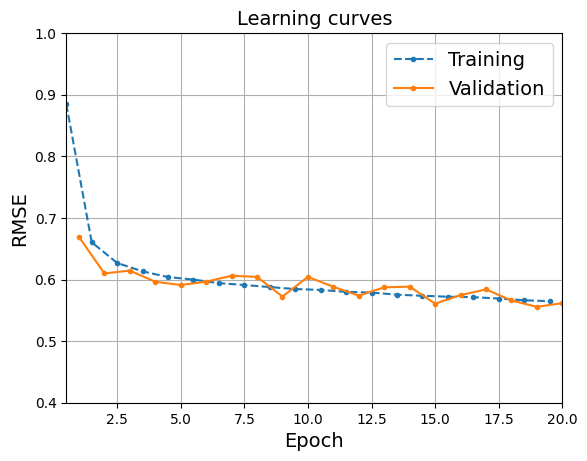

In [61]:
def train2(model, optimizer, criterion, metric, train_loader, valid_loader,
               n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.
        metric.reset()
        for X_batch, y_batch in train_loader:
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

torch.manual_seed(42)
learning_rate = 0.01
model = nn.Sequential(
    nn.Linear(n_features, 50), nn.ReLU(),
    nn.Linear(50, 40), nn.ReLU(),
    nn.Linear(40, 30), nn.ReLU(),
    nn.Linear(30, 1)
)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train2(model, optimizer, mse, rmse, train_loader, valid_loader,
                 n_epochs)

# Since we compute the training metric
plt.plot(np.arange(n_epochs) + 0.5, history["train_metrics"], ".--",
         label="Training")
plt.plot(np.arange(n_epochs) + 1.0, history["valid_metrics"], ".-",
         label="Validation")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
plt.title("Learning curves")
plt.axis((0.5, 20, 0.4, 1.0))
plt.legend()
plt.show()

Now you know how to build, train, and evaluate a regression MLP using PyTorch, and how to use the trained model to make predictions. Great! But so far we have only looked at simple sequential models, composed of a sequence of linear layers and ReLU activation functions. How would you build a more complex, nonsequential model? For this, we will need to build custom modules.

### 3.3.8 Building Nonsequential Custom Modules

#### 3.3.8.1 Wide and Deep Network

One example of a nonsequential neural network is a Wide & Deep neural network. It connects all or part of the inputs directly to the output layer. This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path). The short path can also be used to provide manually engineered features to the neural network. In contrast, a regular MLP forces all the data to flow through the full stack of layers; thus, simple patterns in the data may end up being distorted by this sequence of transformations.

![Wide and Deep Neural Network](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/DL/img/wad.png?raw=1)

Let’s build such a neural network to tackle the California housing dataset. Because this wide and deep architecture is nonsequential, we have to create a custom module. It’s easier than it sounds: just create a class derived from `torch.nn.Module`, then create all the layers you need in the constructor (after calling the base class’s `__init__()` method), and define how these layers should be used by the module in the `forward()` method:

In [62]:
class WideAndDeep(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.deep_stack = nn.Sequential(
            nn.Linear(n_features, 50), nn.ReLU(),
            nn.Linear(50, 40), nn.ReLU(),
        )
        self.output_layer = nn.Linear(40 + n_features, 1)

    def forward(self, X):
        deep_output = self.deep_stack(X)
        wide_and_deep = torch.concat([X, deep_output], dim=1)
        return self.output_layer(wide_and_deep)

Notice that we can use any kind of module inside our custom module: in this example, we use an `nn.Sequential` module to build the “deep” part of our model (it’s actually not that deep; this is just a toy example). It’s the same MLP as earlier, except we separated the output layer because we need to feed it the concatenation of the model’s inputs and the deep part’s outputs. For this same reason, the output layer now has 40 + `n_features` inputs instead of just 40.

In the `forward()` method, we just feed the input X to the deep stack, concatenate the input and the deep stack’s output, and feed the result to the output layer.

Now we can create an instance of our custom module, move it to the GPU, train it, evaluate it, and use it exactly like our previous models:

In [63]:
torch.manual_seed(42)
model = WideAndDeep(n_features).to(device)
learning_rate = 0.002  # the model changed, so did the optimal learning rate

In [64]:
# extra code: train the model, exactly our previous models
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train2(model, optimizer, mse, rmse, train_loader, valid_loader,
                 n_epochs)

Epoch 1/20, train loss: 1.4093, train metric: 1.1873, valid metric: 0.8794
Epoch 2/20, train loss: 0.6105, train metric: 0.7815, valid metric: 0.8410
Epoch 3/20, train loss: 0.5624, train metric: 0.7500, valid metric: 0.7263
Epoch 4/20, train loss: 0.5267, train metric: 0.7256, valid metric: 0.7730
Epoch 5/20, train loss: 0.5050, train metric: 0.7105, valid metric: 0.7300
Epoch 6/20, train loss: 0.4800, train metric: 0.6929, valid metric: 0.6787
Epoch 7/20, train loss: 0.4648, train metric: 0.6819, valid metric: 0.6950
Epoch 8/20, train loss: 0.4505, train metric: 0.6711, valid metric: 0.6437
Epoch 9/20, train loss: 0.4397, train metric: 0.6631, valid metric: 0.7005
Epoch 10/20, train loss: 0.4309, train metric: 0.6564, valid metric: 0.6289
Epoch 11/20, train loss: 0.4227, train metric: 0.6502, valid metric: 0.6604
Epoch 12/20, train loss: 0.4161, train metric: 0.6451, valid metric: 0.6223
Epoch 13/20, train loss: 0.4097, train metric: 0.6402, valid metric: 0.6729
Epoch 14/20, train lo

But what if you want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path? In this case, one approach is to split the inputs inside the `forward()` method, for example:

In [65]:
class WideAndDeepV2(nn.Module):
    # same constructor as earlier, except with adjusted input sizes
    def __init__(self, n_features):
        super().__init__()
        self.deep_stack = nn.Sequential(
            nn.Linear(n_features - 2, 50), nn.ReLU(),
            nn.Linear(50, 40), nn.ReLU(),
            nn.Linear(40, 30), nn.ReLU(),
        )
        self.output_layer = nn.Linear(30 + 5, 1)

    def forward(self, X):
        X_wide = X[:, :5]
        X_deep = X[:, 2:]
        deep_output = self.deep_stack(X_deep)
        wide_and_deep = torch.concat([X_wide, deep_output], dim=1)
        return self.output_layer(wide_and_deep)

In [66]:
torch.manual_seed(42)
model = WideAndDeepV2(n_features).to(device)

In [67]:
# extra code: train the model, exactly our previous models
learning_rate = 0.002
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train2(model, optimizer, mse, rmse, train_loader, valid_loader,
                 n_epochs)

Epoch 1/20, train loss: 1.8482, train metric: 1.3598, valid metric: 0.9100
Epoch 2/20, train loss: 0.6282, train metric: 0.7927, valid metric: 0.8028
Epoch 3/20, train loss: 0.5763, train metric: 0.7591, valid metric: 0.7567
Epoch 4/20, train loss: 0.5413, train metric: 0.7356, valid metric: 0.7290
Epoch 5/20, train loss: 0.5099, train metric: 0.7142, valid metric: 0.7011
Epoch 6/20, train loss: 0.4841, train metric: 0.6958, valid metric: 0.6816
Epoch 7/20, train loss: 0.4656, train metric: 0.6824, valid metric: 0.6670
Epoch 8/20, train loss: 0.4526, train metric: 0.6728, valid metric: 0.6576
Epoch 9/20, train loss: 0.4438, train metric: 0.6662, valid metric: 0.6539
Epoch 10/20, train loss: 0.4380, train metric: 0.6618, valid metric: 0.6498
Epoch 11/20, train loss: 0.4326, train metric: 0.6577, valid metric: 0.6470
Epoch 12/20, train loss: 0.4284, train metric: 0.6546, valid metric: 0.6447
Epoch 13/20, train loss: 0.4253, train metric: 0.6521, valid metric: 0.6452
Epoch 14/20, train lo

This works fine; however, in many cases it’s preferable to just let the model take two separate tensors as input. Let’s see why and how.

#### 3.3.8.2 Multiple Inputs

Some models require multiple inputs that cannot easily be combined into a single tensor. For example, the inputs may have a different number of dimensions (e.g., when you want to feed both images and text to the neural network). To make our Wide & Deep model take two separate inputs, we must start by changing the model’s `forward()` method:

![Handling multiple inputs](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/DL/img/wadv3.png?raw=1)

In [68]:
class WideAndDeepV3(nn.Module):
    # same as WideAndDeepV2
    def __init__(self, n_features):
        super().__init__()
        self.deep_stack = nn.Sequential(
            nn.Linear(n_features - 2, 50), nn.ReLU(),
            nn.Linear(50, 40), nn.ReLU(),
            nn.Linear(40, 30), nn.ReLU(),
        )
        self.output_layer = nn.Linear(30 + 5, 1)

    def forward(self, X_wide, X_deep):
        deep_output = self.deep_stack(X_deep)
        wide_and_deep = torch.concat([X_wide, deep_output], dim=1)
        return self.output_layer(wide_and_deep)

Next, we need to create datasets that return the wide and deep inputs separately:

In [69]:
torch.manual_seed(42)
train_data_wd = TensorDataset(X_train[:, :5], X_train[:, 2:], y_train)
train_loader_wd = DataLoader(train_data_wd, batch_size=32, shuffle=True)
valid_data_wd = TensorDataset(X_valid[:, :5], X_valid[:, 2:], y_valid)
valid_loader_wd = DataLoader(valid_data_wd, batch_size=32)
test_data_wd = TensorDataset(X_test[:, :5], X_test[:, 2:], y_test)
test_loader_wd = DataLoader(test_data_wd, batch_size=32)

Since the data loaders now return three tensors instead of two at each iteration, we need to update the main loop in the evaluation and training functions.

Alternatively, since the order of the inputs matches the order of the `forward()` method’s arguments, we can use Python’s `*` operator to unpack all the inputs returned by the `data_loader` and pass them to the model. The advantage of this implementation is that it will work with models that take any number of inputs, not just two, as long as the order is correct:

In [70]:
def evaluate_multi_in(model, data_loader, metric):
    model.eval()
    metric.reset()  # reset the metric at the beginning
    with torch.no_grad():
        for X_batch_wide, X_batch_deep, y_batch in data_loader:
            X_batch_wide = X_batch_wide.to(device)
            X_batch_deep = X_batch_deep.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch_wide, X_batch_deep)
            metric.update(y_pred, y_batch)  # update it at each iteration
    return metric.compute()  # compute the final result at the end

def train_multi_in(model, optimizer, criterion, metric, train_loader,
                   valid_loader, n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.
        metric.reset()
        for *X_batch_inputs, y_batch in train_loader:
            model.train()
            X_batch_inputs = [X.to(device) for X in X_batch_inputs]
            y_batch = y_batch.to(device)
            y_pred = model(*X_batch_inputs)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_multi_in(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

torch.manual_seed(42)
learning_rate = 0.01
model = WideAndDeepV3(n_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train_multi_in(model, optimizer, mse, rmse, train_loader_wd,
                         valid_loader_wd, n_epochs)

Epoch 1/20, train loss: 0.8366, train metric: 0.9148, valid metric: 0.6892
Epoch 2/20, train loss: 0.4627, train metric: 0.6803, valid metric: 0.6455
Epoch 3/20, train loss: 0.4319, train metric: 0.6572, valid metric: 0.6374
Epoch 4/20, train loss: 0.4259, train metric: 0.6525, valid metric: 0.6512
Epoch 5/20, train loss: 0.4120, train metric: 0.6420, valid metric: 0.6305
Epoch 6/20, train loss: 0.4040, train metric: 0.6356, valid metric: 0.6287
Epoch 7/20, train loss: 0.4005, train metric: 0.6330, valid metric: 0.6252
Epoch 8/20, train loss: 0.3976, train metric: 0.6306, valid metric: 0.6158
Epoch 9/20, train loss: 0.3883, train metric: 0.6230, valid metric: 0.7407
Epoch 10/20, train loss: 0.3866, train metric: 0.6218, valid metric: 0.6063
Epoch 11/20, train loss: 0.3752, train metric: 0.6125, valid metric: 0.5974
Epoch 12/20, train loss: 0.3704, train metric: 0.6087, valid metric: 0.5888
Epoch 13/20, train loss: 0.3677, train metric: 0.6063, valid metric: 0.5981
Epoch 14/20, train lo

When your model has many inputs, it’s easy to make a mistake and mix up the order of the inputs, which can lead to hard-to-debug issues. To avoid this, it can be a good idea to name each input. For this, you can define a custom dataset that returns a dictionary from input names to input values, like this:

In [71]:
class WideAndDeepDataset(torch.utils.data.Dataset):
    def __init__(self, X_wide, X_deep, y):
        self.X_wide = X_wide
        self.X_deep = X_deep
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        input_dict = {"X_wide": self.X_wide[idx], "X_deep": self.X_deep[idx]}
        return input_dict, self.y[idx]

Then create the datasets and data loaders:

In [72]:
torch.manual_seed(42)
train_data_named = WideAndDeepDataset(
    X_wide=X_train[:, :5], X_deep=X_train[:, 2:], y=y_train)
train_loader_named = DataLoader(train_data_named, batch_size=32, shuffle=True)
valid_data_named = WideAndDeepDataset(
    X_wide=X_valid[:, :5], X_deep=X_valid[:, 2:], y=y_valid)
valid_loader_named = DataLoader(valid_data_named, batch_size=32)
test_data_named = WideAndDeepDataset(
    X_wide=X_test[:, :5], X_deep=X_test[:, 2:], y=y_test)
test_loader_named = DataLoader(test_data_named, batch_size=32)

Once again, we also need to update the main loop in the evaluation and training functions:

In [73]:
def evaluate_named(model, data_loader, metric):
    model.eval()
    metric.reset()  # reset the metric at the beginning
    with torch.no_grad():
        for inputs, y_batch in data_loader:
            inputs = {name: X.to(device) for name, X in inputs.items()}
            y_batch = y_batch.to(device)
            y_pred = model(X_wide=inputs["X_wide"], X_deep=inputs["X_deep"])
            metric.update(y_pred, y_batch)
    return metric.compute()  # compute the final result at the end

def train_named(model, optimizer, criterion, metric, train_loader,
                   valid_loader, n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.
        metric.reset()
        for inputs, y_batch in train_loader:
            model.train()
            inputs = {name: X.to(device) for name, X in inputs.items()}
            y_batch = y_batch.to(device)
            y_pred = model(**inputs)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_named(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

torch.manual_seed(42)
learning_rate = 0.01
model = WideAndDeepV3(n_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train_named(model, optimizer, mse, rmse, train_loader_named,
                      valid_loader_named, n_epochs)

Epoch 1/20, train loss: 0.8366, train metric: 0.9148, valid metric: 0.6892
Epoch 2/20, train loss: 0.4627, train metric: 0.6803, valid metric: 0.6455
Epoch 3/20, train loss: 0.4319, train metric: 0.6572, valid metric: 0.6374
Epoch 4/20, train loss: 0.4259, train metric: 0.6525, valid metric: 0.6512
Epoch 5/20, train loss: 0.4120, train metric: 0.6420, valid metric: 0.6305
Epoch 6/20, train loss: 0.4040, train metric: 0.6356, valid metric: 0.6287
Epoch 7/20, train loss: 0.4005, train metric: 0.6330, valid metric: 0.6252
Epoch 8/20, train loss: 0.3976, train metric: 0.6306, valid metric: 0.6158
Epoch 9/20, train loss: 0.3883, train metric: 0.6230, valid metric: 0.7407
Epoch 10/20, train loss: 0.3866, train metric: 0.6218, valid metric: 0.6063
Epoch 11/20, train loss: 0.3752, train metric: 0.6125, valid metric: 0.5974
Epoch 12/20, train loss: 0.3704, train metric: 0.6087, valid metric: 0.5888
Epoch 13/20, train loss: 0.3677, train metric: 0.6063, valid metric: 0.5981
Epoch 14/20, train lo

Alternatively, since all the input names match the `forward()` method’s argument names, we can use Python’s `**` operator to unpack all the tensors in the `inputs` dictionary and pass them as named arguments to the model: `y_pred = model(**inputs)`.

Now that you know how to build sequential and nonsequential models with one or more inputs, let’s look at models with multiple outputs.

#### 3.3.8.3 Multiple Outputs

There are many use cases where you may need a neural net with multiple outputs:

* The task may demand it. For instance, you may want to locate and classify the main object in a picture. This is both a regression task and a classification task.
* Similarly, you may have multiple independent tasks based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks. For example, you could perform *multitask classification* on pictures of faces, using one output to classify the person’s facial expression (smiling, surprised, etc.) and another output to identify whether they are wearing glasses or not.
* Another use case is regularization (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). For example, you may want to add an auxiliary output in a neural network architecture to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

![Handling multiple outputs, in this example to add an auxiliary output for regularization](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/DL/img/multiout.png?raw=1)

Let’s add an auxiliary output to our Wide & Deep model to ensure the deep part can make good predictions on its own. Since the deep stack’s output dimension is 40, and the targets have a single dimension, we must add an `nn.Linear` layer for the auxiliary output to go from 40 dimensions down to 1. We also need to make the `forward()` method compute the auxiliary output, and return both the main output and the auxiliary output:

In [74]:
class WideAndDeepV4(nn.Module):
    # same as earlier
    def __init__(self, n_features):
        super().__init__()
        self.deep_stack = nn.Sequential(
            nn.Linear(n_features - 2, 50), nn.ReLU(),
            nn.Linear(50, 40), nn.ReLU(),
            nn.Linear(40, 30), nn.ReLU(),
        )
        self.output_layer = nn.Linear(30 + 5, 1)
        self.aux_output_layer = nn.Linear(30, 1)

    def forward(self, X_wide, X_deep):
        deep_output = self.deep_stack(X_deep)
        wide_and_deep = torch.concat([X_wide, deep_output], dim=1)
        main_output = self.output_layer(wide_and_deep)
        aux_output = self.aux_output_layer(deep_output)
        return main_output, aux_output

Next, we need to update the main loop in the training function:

In [75]:
import torchmetrics

def evaluate_multi_out(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for inputs, y_batch in data_loader:
            inputs = {name: X.to(device) for name, X in inputs.items()}
            y_batch = y_batch.to(device)
            y_pred, _ = model(**inputs)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train_multi_out(model, optimizer, criterion, metric, train_loader,
                   valid_loader, n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.
        metric.reset()
        for inputs, y_batch in train_loader:
            model.train()
            inputs = {name: X.to(device) for name, X in inputs.items()}
            y_batch = y_batch.to(device)
            y_pred, y_pred_aux = model(**inputs)
            main_loss = criterion(y_pred, y_batch)
            aux_loss = criterion(y_pred_aux, y_batch)
            loss = 0.8 * main_loss + 0.2 * aux_loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        mean_loss = total_loss / len(train_loader)
        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_multi_out(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

torch.manual_seed(42)
learning_rate = 0.01
model = WideAndDeepV4(n_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train_multi_out(model, optimizer, mse, rmse, train_loader_named,
                          valid_loader_named, n_epochs)

Epoch 1/20, train loss: 1.0693, train metric: 0.9506, valid metric: 0.7085
Epoch 2/20, train loss: 0.5817, train metric: 0.6946, valid metric: 0.6607
Epoch 3/20, train loss: 0.5010, train metric: 0.6581, valid metric: 0.6425
Epoch 4/20, train loss: 0.4690, train metric: 0.6497, valid metric: 0.6654
Epoch 5/20, train loss: 0.4503, train metric: 0.6420, valid metric: 0.6338
Epoch 6/20, train loss: 0.4387, train metric: 0.6373, valid metric: 0.6563
Epoch 7/20, train loss: 0.4315, train metric: 0.6330, valid metric: 0.6193
Epoch 8/20, train loss: 0.4249, train metric: 0.6302, valid metric: 0.6167
Epoch 9/20, train loss: 0.4116, train metric: 0.6202, valid metric: 0.6450
Epoch 10/20, train loss: 0.4085, train metric: 0.6198, valid metric: 0.5938
Epoch 11/20, train loss: 0.4073, train metric: 0.6197, valid metric: 0.5959
Epoch 12/20, train loss: 0.3914, train metric: 0.6078, valid metric: 0.6073
Epoch 13/20, train loss: 0.3847, train metric: 0.6033, valid metric: 0.5815
Epoch 14/20, train lo

Notice that the model now returns both the main predictions `y_pred` and the auxiliary predictions `y_pred_aux`. In this example, we can use the same targets and the same loss function to compute the main output’s loss and the auxiliary output’s loss. In other cases, you may have different targets and loss functions for each output, in which case you would need to create a custom dataset to return all the necessary targets. Once we have a loss for each output, we must combine them into a single loss that will be minimized by gradient descent. In general, this final loss is just a weighted sum of all the output losses. In this example, we use a higher weight for the main loss (0.8), because that’s what we care about the most, and a lower weight for the auxiliary loss (0.2). This ratio is a regularization hyperparameter that you can tune.

We also need to update the main loop in the evaluation function. However, in this case we can just ignore the auxiliary output, since we only really care about the main output—the auxiliary output is just there for regularization during training.

You can now build and train all sorts of neural net architectures, combining predefined modules and custom modules in any way you please, and with any number of inputs and outputs. The flexibility of neural networks is one of their main qualities. But so far we have only tackled a regression task, so let’s now turn to classification.

### 3.3.9 Building an Image Classifier with PyTorch

#### 3.3.9.1 Using TorchVision to Load the Dataset

We will tackle the Fashion MNIST dataset, so the first thing we need to do is to download the dataset. The TorchVision library is an important part of the PyTorch ecosystem: it provides many tools for computer vision, including utility functions to download common datasets, such as MNIST or Fashion MNIST, as well as pretrained models for various computer vision tasks, functions to transform images (e.g., crop, rotate, resize, etc.), and more. It is preinstalled on Colab, so let’s go ahead and use it to load Fashion MNIST. It is already split into a training set (60,000 images) and a test set (10,000 images), but we’ll hold out the last 5,000 images from the training set for validation, using PyTorch’s `random_split()` function:

In [76]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]


After the imports and before loading the datasets, we create a `toTensor` object. What’s that about? Well, by default, the `FashionMNIST` class loads images as PIL (Python Image Library) images, with integer pixel values ranging from 0 to 255. But we need PyTorch float tensors instead, with scaled pixel values. Luckily, TorchVision datasets accept a `transform` argument which lets you pass a preprocessing function that will get executed on the fly whenever the data is accessed (there’s also a `target_transform` argument if you need to preprocess the targets). TorchVision provides many transform objects that you can use for this (most of these transforms are PyTorch modules).

In this code, we create a `Compose` transform to chain two transforms: a `ToImage` transform followed by a `ToDtype` transform. `ToImage` converts various formats—including PIL images, NumPy arrays, and tensors—to TorchVision’s `Image` class, which is a subclass of `Tensor`. The `ToDtype` transform converts the data type, in this case to 32-bit floats. We also set its `scale` argument to `True` to ensure the values get scaled between 0.0 and 1.0.

Next, we load the dataset: first the training and validation data, then the test data. The `root` argument is the path to the directory where TorchVision will create a subdirectory for the Fashion MNIST dataset. The `train` argument indicates whether you want to load the training set (`True` by default) or the test set. The `download` argument indicates whether to download the dataset if it cannot be found locally (`False` by default). And we also set `transform=toTensor` to use our custom preprocessing pipeline.

As usual, we must create data loaders:

In [77]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Now let’s look at the first image in the training set:

In [78]:
X_sample, y_sample = train_data[0]

In [79]:
X_sample.shape

torch.Size([1, 28, 28])

Each image tensor has 3 dimensions, and its shape is: `[1, 28, 28]`. The first dimension is the *channel* dimension. For grayscale images, there is a single channel (color images usually have three channels). The other two dimensions are the height and width dimensions. For example, `X_sample[0, 2, 4]` represents the pixel located in channel 0, row 2, column 4. In Fashion MNIST, a larger value means a darker pixel.

In [80]:
X_sample.dtype

torch.float32

As for the targets, they are integers from 0 to 9, and we can interpret them using the `class_names` array. In fact, many datasets—including `FashionMNIST`—have a classes attribute containing the list of class names. For example, here’s how we can tell that the sample image represents an ankle boot:

In [81]:
train_and_valid_data.classes[y_sample]

'Ankle boot'

#### 3.3.9.2 Building the Classifier

Let’s build a custom module for a classification MLP with two hidden layers:

In [82]:
class ImageClassifier(nn.Module):
    def __init__(self, n_inputs, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_inputs, n_hidden1),
            nn.ReLU(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.ReLU(),
            nn.Linear(n_hidden2, n_classes)
        )

    def forward(self, X):
        return self.mlp(X)

torch.manual_seed(42)
model = ImageClassifier(n_inputs=1 * 28 * 28, n_hidden1=300, n_hidden2=100,
                        n_classes=10).to(device)
xentropy = nn.CrossEntropyLoss()

There are a few things to note in this code:

* First, the model is composed of a single sequence of layers, which is why we used the `nn.Sequential` module. We did not have to create a custom module; we could have written `model = nn.Sequential(...)` instead, but it’s generally preferable to wrap your models in custom modules, as it makes your code easier to deploy and reuse, and it’s also easier to tune the hyperparameters.
* The model starts with an `nn.Flatten` layer: this layer does not have any parameters, it just reshapes each input sample to a single dimension, which is needed for the `nn.Linear` layers. For example, a batch of 32 Fashion MNIST images has a shape of `[32, 1, 28, 28]`, but after going through the `nn.Flatten` layer, it ends up with a shape of `[32, 784]` (since 28 × 28 = 784).
* The first hidden layer must have the correct number of inputs (28 × 28 = 784), and the output layer must have the correct number of outputs (10, one per class).
* We use a ReLU activation function after each hidden layer, and no activation function at all after the output layer.
* Since this is a multiclass classification task, we use `nn.CrossEntropyLoss`. It accepts either class indices as targets (as in this example), or class probabilities (such as one-hot vectors).

PyTorch’s `nn.CrossEntropyLoss` computes the cross-entropy loss directly from the logits (i.e., the class scores), rather than from the class probabilities. This bypasses some costly computations during training (e.g., logarithms and exponentials that cancel out), saving both compute and RAM. It’s also more numerically stable. However, the downside is that the model must output logits, which means that we will have to call the softmax function manually on the logits whenever we want class probabilities, as we will see shortly.

**Note**: For binary classification tasks, you must use a single output neuron in the output layer, and use the `nn.BCEWithLogitsLoss` (BCE stands for binary cross-entropy). The model outputs logits, so you must apply the sigmoid function to get estimated probabilities (for the positive class). Alternatively, you can add the `nn.Sigmoid` activation function to the output layer, and use the `nn.BCELoss`: the model will then output estimated probabilities directly (but it’s a bit slower and less numerically stable).

For multilabel binary classification, the only difference is that you must have one neuron per label in the output layer.

Now we can train the model as usual (e.g., using the train() function with an SGD optimizer). To evaluate the model, we can use the Accuracy streaming metric from the torchmetrics library, and move it to the GPU:

In [83]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
_ = train2(model, optimizer, xentropy, accuracy, train_loader, valid_loader,
           n_epochs)

Epoch 1/20, train loss: 0.6058, train metric: 0.7816, valid metric: 0.8416
Epoch 2/20, train loss: 0.4059, train metric: 0.8497, valid metric: 0.8372
Epoch 3/20, train loss: 0.3633, train metric: 0.8663, valid metric: 0.8530
Epoch 4/20, train loss: 0.3359, train metric: 0.8762, valid metric: 0.8660
Epoch 5/20, train loss: 0.3147, train metric: 0.8835, valid metric: 0.8754
Epoch 6/20, train loss: 0.2991, train metric: 0.8881, valid metric: 0.8666
Epoch 7/20, train loss: 0.2859, train metric: 0.8916, valid metric: 0.8622
Epoch 8/20, train loss: 0.2745, train metric: 0.8971, valid metric: 0.8722
Epoch 9/20, train loss: 0.2639, train metric: 0.9007, valid metric: 0.8834
Epoch 10/20, train loss: 0.2531, train metric: 0.9041, valid metric: 0.8810
Epoch 11/20, train loss: 0.2463, train metric: 0.9068, valid metric: 0.8850
Epoch 12/20, train loss: 0.2353, train metric: 0.9109, valid metric: 0.8910
Epoch 13/20, train loss: 0.2303, train metric: 0.9125, valid metric: 0.8870
Epoch 14/20, train lo

The model reaches around 92.8% accuracy on the training set, and 87.2% accuracy on the validation set (the results might differ a bit depending on the hardware accelerator you use). This means there’s a little bit of overfitting going on, so you may want to reduce the number of neurons or add some regularization.

Now that the model is trained, we can use it to make predictions on new images. As an example, let’s make predictions for the first batch in the validation set, and look at the results for the first three images:



In [84]:
model.eval()
X_new, y_new = next(iter(valid_loader))
X_new = X_new[:3].to(device)
with torch.no_grad():
    y_pred_logits = model(X_new)
y_pred = y_pred_logits.argmax(dim=1)  # index of the largest logit
y_pred

tensor([7, 4, 2], device='cuda:0')

In [85]:
[train_and_valid_data.classes[index] for index in y_pred]

['Sneaker', 'Coat', 'Pullover']

In [86]:
y_new[:3]

tensor([7, 4, 2])

For each image, the predicted class is the one with the highest logit. In this example, all three predictions are correct!

But what if we want the model’s estimated probabilities? For this, we need to compute the softmax of the logits manually, since the model does not include the softmax activation function on the output layer, as we discussed earlier. We could create an `nn.Softmax` module and pass it the logits, but we can also just call the `softmax()` function, which is just one of many functions you will find in the `torch.nn.functional` module (by convention, this module is usually imported as `F`). It doesn’t make much difference, it just avoids creating a module instance that we don’t need:

In [87]:
import torch.nn.functional as F
y_proba = F.softmax(y_pred_logits, dim=1)
if device == "mps":
    y_proba = y_proba.cpu()
y_proba.round(decimals=3)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0000, 0.9110, 0.0000,
         0.0880],
        [0.0000, 0.0000, 0.0040, 0.0000, 0.9960, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.6250, 0.0000, 0.3350, 0.0000, 0.0390, 0.0000, 0.0000,
         0.0000]], device='cuda:0')

The model is very confident about the first two predictions.

**Tip**: If you wish to apply label smoothing during training, just set the label_smoothing hyperparameter of the nn.CrossEntropyLoss to the amount of smoothing you wish, between 0 and 1 (e.g., 0.05).

It can often be useful to get the model’s top *k* predictions. For this, we can use the `torch.topk()` function, which returns a tuple containing both the top *k* values and their indices:

In [88]:
y_top4_values, y_top4_indices = torch.topk(y_pred_logits, k=4, dim=1)
y_top4_probas = F.softmax(y_top4_values, dim=1)
if device == "mps":
    y_top4_probas = y_top4_probas.cpu()
y_top4_probas.round(decimals=3)

tensor([[0.9110, 0.0880, 0.0010, 0.0000],
        [0.9960, 0.0040, 0.0000, 0.0000],
        [0.6250, 0.3350, 0.0390, 0.0000]], device='cuda:0')

In [89]:
y_top4_indices

tensor([[7, 9, 5, 8],
        [4, 2, 6, 0],
        [2, 4, 6, 0]], device='cuda:0')

For the first image, the model’s best guess is class 7 (Sneaker) with 91.1% confidence, its second best guess is class 9 (Ankle boot) with 8.8% confidence, and so on.

**Tip**: The Fashion MNIST dataset is balanced, meaning it has the same number of instances of each class. When dealing with an unbalanced dataset, you should generally give more weight to the rare classes and less weight to the frequent ones, or else your model will be biased toward the more frequent classes. You can do this by setting the `weight` argument of the `nn.CrossEntropyLoss`. For example, if there are three classes with 900, 700, and 400 instances, respectively (i.e., 2000 instances in total), then the respective weights should be 2000/900, 2000/700, and 2000/400. It’s preferable to normalize these weights to ensure they add up to 1, so in this example you would set `weight=torch.tensor([0.2205, 0.2835, 0.4961])`.

### 3.3.10 Fine-Tuning with Optuna

What if you want to go further and automatically search for good hyperparameter values? You will usually get great results by using a dedicated fine-tuning library such as [Optuna](https://optuna.org), [Ray Tune](https://docs.ray.io), or [Hyperopt](https://hyperopt.github.io/hyperopt). These libraries offer several powerful tuning strategies, and they’re highly customizable.

Let’s look at an example using Optuna. It is not preinstalled on Colab, so we need to install it using

```python
%pip install optuna
```

Let’s tune the learning rate and the number of neurons in the hidden layers (for simplicity, we will use the same number of neurons in both hidden layers). First, we need to define a function that Optuna will call many times to perform hyperparameter tuning: this function must take a `Trial` object and use it to ask Optuna for hyperparameter values, and then use these hyperparameter values to build and train a model. Finally, the function must evaluate the model (typically on the validation set) and return the metric:

In [90]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    n_hidden = trial.suggest_int("n_hidden", 20, 300)
    model = ImageClassifier(n_inputs=1 * 28 * 28, n_hidden1=n_hidden,
                            n_hidden2=n_hidden, n_classes=10).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    accuracy = accuracy.to(device)
    history = train2(model, optimizer, xentropy, accuracy, train_loader,
                     valid_loader, n_epochs=10)
    validation_accuracy = max(history["valid_metrics"])
    return validation_accuracy

The `suggest_float()` and `suggest_int()` methods let us ask Optuna for a good hyperparameter value in a given range (Optuna also provides a `suggest_categorical()` method). For the `learning_rate` hyperparameter, we ask for a value between $10^{-5}$ and $10^{-1}$, and since we don’t know what the optimal scale is, we add `log=True`: this will make Optuna sample values from a log distribution, which makes it explore all possible scales. If we used the default uniform distribution instead, Optuna would be very unlikely to explore tiny values.

To start hyperparameter tuning, we create a `Study` object and call its `optimize()` method, passing it the objective function we just defined, as well as the number of trials to run (i.e., the number of times Optuna should call the objective function). Since our objective function returns a score—higher is better—we set `direction="maximize"` when creating the study (by default, Optuna tries to *minimize* the objective). To ensure reproducibility, we also set PyTorch’s random seed, as well as the random seed used by Optuna’s sampler:

In [91]:
torch.manual_seed(42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=5)

[I 2025-12-01 06:46:07,394] A new study created in memory with name: no-name-2d8208ff-1974-4989-8640-7ff0a6153d59


Epoch 1/10, train loss: 2.2769, train metric: 0.1471, valid metric: 0.1860
Epoch 2/10, train loss: 2.2093, train metric: 0.2794, valid metric: 0.3500
Epoch 3/10, train loss: 2.1164, train metric: 0.4110, valid metric: 0.4554
Epoch 4/10, train loss: 1.9776, train metric: 0.5137, valid metric: 0.5562
Epoch 5/10, train loss: 1.7867, train metric: 0.5826, valid metric: 0.6026
Epoch 6/10, train loss: 1.5775, train metric: 0.6184, valid metric: 0.6228
Epoch 7/10, train loss: 1.3978, train metric: 0.6288, valid metric: 0.6326
Epoch 8/10, train loss: 1.2605, train metric: 0.6360, valid metric: 0.6372
Epoch 9/10, train loss: 1.1572, train metric: 0.6468, valid metric: 0.6424


[I 2025-12-01 06:48:36,917] Trial 0 finished with value: 0.6435999870300293 and parameters: {'learning_rate': 0.00031489116479568613, 'n_hidden': 287}. Best is trial 0 with value: 0.6435999870300293.


Epoch 10/10, train loss: 1.0782, train metric: 0.6537, valid metric: 0.6436
Epoch 1/10, train loss: 1.1459, train metric: 0.6229, valid metric: 0.7338
Epoch 2/10, train loss: 0.6108, train metric: 0.7841, valid metric: 0.7992
Epoch 3/10, train loss: 0.5203, train metric: 0.8169, valid metric: 0.8094
Epoch 4/10, train loss: 0.4810, train metric: 0.8302, valid metric: 0.8310
Epoch 5/10, train loss: 0.4557, train metric: 0.8404, valid metric: 0.8352
Epoch 6/10, train loss: 0.4387, train metric: 0.8460, valid metric: 0.8442
Epoch 7/10, train loss: 0.4240, train metric: 0.8512, valid metric: 0.8408
Epoch 8/10, train loss: 0.4123, train metric: 0.8566, valid metric: 0.8514
Epoch 9/10, train loss: 0.3998, train metric: 0.8601, valid metric: 0.8532


[I 2025-12-01 06:51:07,017] Trial 1 finished with value: 0.8547999858856201 and parameters: {'learning_rate': 0.008471801418819975, 'n_hidden': 188}. Best is trial 1 with value: 0.8547999858856201.


Epoch 10/10, train loss: 0.3897, train metric: 0.8638, valid metric: 0.8548
Epoch 1/10, train loss: 2.3069, train metric: 0.1144, valid metric: 0.1082
Epoch 2/10, train loss: 2.2993, train metric: 0.1231, valid metric: 0.1294
Epoch 3/10, train loss: 2.2914, train metric: 0.1606, valid metric: 0.1710
Epoch 4/10, train loss: 2.2836, train metric: 0.1839, valid metric: 0.1840
Epoch 5/10, train loss: 2.2762, train metric: 0.1891, valid metric: 0.1856
Epoch 6/10, train loss: 2.2692, train metric: 0.1910, valid metric: 0.1898
Epoch 7/10, train loss: 2.2623, train metric: 0.1933, valid metric: 0.1932
Epoch 8/10, train loss: 2.2554, train metric: 0.2000, valid metric: 0.2022
Epoch 9/10, train loss: 2.2485, train metric: 0.2122, valid metric: 0.2160


[I 2025-12-01 06:53:35,767] Trial 2 finished with value: 0.23340000212192535 and parameters: {'learning_rate': 4.207988669606632e-05, 'n_hidden': 63}. Best is trial 1 with value: 0.8547999858856201.


Epoch 10/10, train loss: 2.2414, train metric: 0.2299, valid metric: 0.2334
Epoch 1/10, train loss: 2.3035, train metric: 0.1373, valid metric: 0.1526
Epoch 2/10, train loss: 2.3005, train metric: 0.1569, valid metric: 0.1724
Epoch 3/10, train loss: 2.2975, train metric: 0.1755, valid metric: 0.1896
Epoch 4/10, train loss: 2.2945, train metric: 0.1941, valid metric: 0.2132
Epoch 5/10, train loss: 2.2914, train metric: 0.2105, valid metric: 0.2288
Epoch 6/10, train loss: 2.2884, train metric: 0.2261, valid metric: 0.2418
Epoch 7/10, train loss: 2.2853, train metric: 0.2419, valid metric: 0.2580
Epoch 8/10, train loss: 2.2823, train metric: 0.2581, valid metric: 0.2742
Epoch 9/10, train loss: 2.2792, train metric: 0.2736, valid metric: 0.2918


[I 2025-12-01 06:56:05,015] Trial 3 finished with value: 0.30959999561309814 and parameters: {'learning_rate': 1.7073967431528103e-05, 'n_hidden': 263}. Best is trial 1 with value: 0.8547999858856201.


Epoch 10/10, train loss: 2.2761, train metric: 0.2897, valid metric: 0.3096
Epoch 1/10, train loss: 1.8379, train metric: 0.4869, valid metric: 0.6208
Epoch 2/10, train loss: 0.9751, train metric: 0.6666, valid metric: 0.6978
Epoch 3/10, train loss: 0.7608, train metric: 0.7253, valid metric: 0.7416
Epoch 4/10, train loss: 0.6704, train metric: 0.7639, valid metric: 0.7720
Epoch 5/10, train loss: 0.6108, train metric: 0.7913, valid metric: 0.7906
Epoch 6/10, train loss: 0.5687, train metric: 0.8053, valid metric: 0.8050
Epoch 7/10, train loss: 0.5386, train metric: 0.8164, valid metric: 0.8082
Epoch 8/10, train loss: 0.5158, train metric: 0.8243, valid metric: 0.8214
Epoch 9/10, train loss: 0.4988, train metric: 0.8279, valid metric: 0.8220


[I 2025-12-01 06:58:32,788] Trial 4 finished with value: 0.8220000267028809 and parameters: {'learning_rate': 0.002537815508265664, 'n_hidden': 218}. Best is trial 1 with value: 0.8547999858856201.


Epoch 10/10, train loss: 0.4842, train metric: 0.8330, valid metric: 0.8092


By default, Optuna uses the *Tree-structured Parzen Estimator* (TPE) algorithm to optimize the hyperparameters: this is a sequential model-based optimization algorithm, meaning it learns from past results to better select promising hyperparameters. In other words, Optuna starts with random hyperparameter values, but it progressively focuses its search on the most promising regions of the hyperparameter space. This allows Optuna to find much better hyperparameters than random search in the same amount of time.

**Tip**: You can add more hyperparameters to the search space, such as the batch size, the type of optimizer, the number of hidden layers, or the type of activation function, but remember that the search space will grow exponentially as you add more hyperparameters, so make sure it’s worth the extra search time and compute.

Once Optuna is done, you can look at the best hyperparameters it found, as well as the corresponding validation accuracy:

In [92]:
study.best_params

{'learning_rate': 0.008471801418819975, 'n_hidden': 188}

In [93]:
study.best_value

0.8547999858856201

This is slightly better than the performance we got earlier. If you increase `n_trials` up to 50 or more, you will get much better results, but of course it will take hours to run. You can also just run `optimize()` repeatedly and stop once you are happy with the performance.

**Tip**: Optuna can also run trials in parallel across multiple machines, which can offer a near linear speed boost. For this, you will need to set up a SQL database (e.g., SQLite or PostgreSQL), and set the `storage` parameter of the `create_study()` function to point to that database. You also need to set the study’s name via the `study_name` parameter, and set `load_if_exists=True`. After that, you can copy your hyperparameter tuning script to multiple machines, and run it on each one (if you are using random seeds, make sure they are different on each machine). The scripts will work in parallel, reading and writing the trial results to the database. This has the additional benefit of keeping a full log of all your experiment results.

You may have noticed that we assumed that the `objective()` function had direct access to the training set and validation, presumably via global variables. In general, it’s much cleaner to pass them as extra arguments to the `objective()` function, for example, like this:

In [94]:
def objective(trial, train_loader, valid_loader):
    # the rest of the function remains the same as above
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    n_hidden = trial.suggest_int("n_hidden", 20, 300)
    model = ImageClassifier(n_inputs=1 * 28 * 28, n_hidden1=n_hidden,
                            n_hidden2=n_hidden, n_classes=10).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    accuracy = accuracy.to(device)
    best_validation_accuracy = 0.0
    # train for multiple epochs, reporting intermediate results
    for epoch in range(n_epochs):
        history = train2(model, optimizer, xentropy, accuracy, train_loader,
                         valid_loader, n_epochs=1)
        validation_accuracy = max(history["valid_metrics"])
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
        trial.report(validation_accuracy, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return best_validation_accuracy

In [95]:
objective_with_data = lambda trial: objective(
    trial, train_loader=train_loader, valid_loader=valid_loader)

To set the extra arguments (the dataset loaders in this case), we just create a lambda function when needed and pass it to the `optimize()` method. Alternatively, you can use the `functools.partial()` function which creates a thin wrapper function around the given callable to provide default values for any number of arguments:

In [96]:
from functools import partial

objective_with_data = partial(objective, train_loader=train_loader,
                              valid_loader=valid_loader)

In [97]:
objective_with_data

functools.partial(<function objective at 0x79aa3120be20>, train_loader=<torch.utils.data.dataloader.DataLoader object at 0x79abae871400>, valid_loader=<torch.utils.data.dataloader.DataLoader object at 0x79aa42d31dc0>)

**Tip**: It’s often possible to quickly tell that a trial is absolutely terrible: for example, when the loss shoots up during the first epoch, or when the model barely improves during the first few epochs. In such a case, it’s a good idea to interrupt training early to avoid wasting time and compute. You can simply return the model’s current validation accuracy and hope that Optuna will learn to avoid this region of hyperparameter space. Alternatively, you can interrupt training by raising the `optuna.TrialPruned` exception: this tells Optuna to ignore this trial altogether. In many cases, this leads to a more efficient search because it avoids polluting Optuna’s search algorithm with many noisy model evaluations.

Optuna comes with several `Pruner` classes that can detect and prune bad trials. For example, the `MedianPruner` will prune trials whose performance is below the median performance, at regular intervals during training. It starts pruning after a given number of trials have completed, controlled by `n_startup_trials` (5 by default). For each trial after that, it lets training start for a few epochs, controlled by `n_warmup_steps` (0 by default); then every few epochs (controlled by `interval_steps`), it ensures that the model’s performance is better than the median performance at the same epoch in past trials. To use this pruner, create an instance and pass it to the `create_study()` method:

In [98]:
torch.manual_seed(42)
sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", sampler=sampler,
                            pruner=pruner)
study.optimize(objective_with_data, n_trials=20)

[I 2025-12-01 06:58:32,834] A new study created in memory with name: no-name-b1f1f2ff-4366-4797-844a-d40ce0c52f7b


Epoch 1/1, train loss: 2.2769, train metric: 0.1471, valid metric: 0.1860
Epoch 1/1, train loss: 2.2093, train metric: 0.2794, valid metric: 0.3500
Epoch 1/1, train loss: 2.1164, train metric: 0.4110, valid metric: 0.4554
Epoch 1/1, train loss: 1.9776, train metric: 0.5137, valid metric: 0.5562
Epoch 1/1, train loss: 1.7867, train metric: 0.5826, valid metric: 0.6026
Epoch 1/1, train loss: 1.5775, train metric: 0.6184, valid metric: 0.6228
Epoch 1/1, train loss: 1.3978, train metric: 0.6288, valid metric: 0.6326
Epoch 1/1, train loss: 1.2605, train metric: 0.6360, valid metric: 0.6372
Epoch 1/1, train loss: 1.1572, train metric: 0.6468, valid metric: 0.6424
Epoch 1/1, train loss: 1.0782, train metric: 0.6537, valid metric: 0.6436
Epoch 1/1, train loss: 1.0162, train metric: 0.6611, valid metric: 0.6530
Epoch 1/1, train loss: 0.9665, train metric: 0.6689, valid metric: 0.6620
Epoch 1/1, train loss: 0.9258, train metric: 0.6761, valid metric: 0.6700
Epoch 1/1, train loss: 0.8919, train m

[I 2025-12-01 07:03:30,077] Trial 0 finished with value: 0.7089999914169312 and parameters: {'learning_rate': 0.00031489116479568613, 'n_hidden': 287}. Best is trial 0 with value: 0.7089999914169312.


Epoch 1/1, train loss: 0.7647, train metric: 0.7196, valid metric: 0.7082
Epoch 1/1, train loss: 1.1485, train metric: 0.6157, valid metric: 0.7332
Epoch 1/1, train loss: 0.6133, train metric: 0.7864, valid metric: 0.8082
Epoch 1/1, train loss: 0.5200, train metric: 0.8179, valid metric: 0.8136
Epoch 1/1, train loss: 0.4783, train metric: 0.8311, valid metric: 0.8232
Epoch 1/1, train loss: 0.4533, train metric: 0.8402, valid metric: 0.8020
Epoch 1/1, train loss: 0.4357, train metric: 0.8465, valid metric: 0.8446
Epoch 1/1, train loss: 0.4211, train metric: 0.8510, valid metric: 0.8276
Epoch 1/1, train loss: 0.4083, train metric: 0.8562, valid metric: 0.8398
Epoch 1/1, train loss: 0.3981, train metric: 0.8606, valid metric: 0.8532
Epoch 1/1, train loss: 0.3881, train metric: 0.8640, valid metric: 0.8582
Epoch 1/1, train loss: 0.3782, train metric: 0.8663, valid metric: 0.8532
Epoch 1/1, train loss: 0.3699, train metric: 0.8693, valid metric: 0.8566
Epoch 1/1, train loss: 0.3631, train m

[I 2025-12-01 07:08:24,936] Trial 1 finished with value: 0.8679999709129333 and parameters: {'learning_rate': 0.008471801418819975, 'n_hidden': 188}. Best is trial 1 with value: 0.8679999709129333.


Epoch 1/1, train loss: 0.3191, train metric: 0.8862, valid metric: 0.8638
Epoch 1/1, train loss: 2.2998, train metric: 0.1078, valid metric: 0.1152
Epoch 1/1, train loss: 2.2923, train metric: 0.1305, valid metric: 0.1432
Epoch 1/1, train loss: 2.2856, train metric: 0.1605, valid metric: 0.1704
Epoch 1/1, train loss: 2.2797, train metric: 0.1872, valid metric: 0.1912
Epoch 1/1, train loss: 2.2744, train metric: 0.2091, valid metric: 0.2114
Epoch 1/1, train loss: 2.2693, train metric: 0.2230, valid metric: 0.2216
Epoch 1/1, train loss: 2.2643, train metric: 0.2332, valid metric: 0.2320
Epoch 1/1, train loss: 2.2591, train metric: 0.2408, valid metric: 0.2380
Epoch 1/1, train loss: 2.2538, train metric: 0.2456, valid metric: 0.2424
Epoch 1/1, train loss: 2.2481, train metric: 0.2493, valid metric: 0.2456
Epoch 1/1, train loss: 2.2422, train metric: 0.2511, valid metric: 0.2464
Epoch 1/1, train loss: 2.2360, train metric: 0.2534, valid metric: 0.2476
Epoch 1/1, train loss: 2.2296, train m

[I 2025-12-01 07:13:19,298] Trial 2 finished with value: 0.25380000472068787 and parameters: {'learning_rate': 4.207988669606632e-05, 'n_hidden': 63}. Best is trial 1 with value: 0.8679999709129333.


Epoch 1/1, train loss: 2.1751, train metric: 0.2610, valid metric: 0.2538
Epoch 1/1, train loss: 2.3015, train metric: 0.0997, valid metric: 0.1028
Epoch 1/1, train loss: 2.2984, train metric: 0.1009, valid metric: 0.1050
Epoch 1/1, train loss: 2.2953, train metric: 0.1051, valid metric: 0.1124
Epoch 1/1, train loss: 2.2923, train metric: 0.1160, valid metric: 0.1270
Epoch 1/1, train loss: 2.2894, train metric: 0.1347, valid metric: 0.1496
Epoch 1/1, train loss: 2.2865, train metric: 0.1548, valid metric: 0.1652
Epoch 1/1, train loss: 2.2837, train metric: 0.1699, valid metric: 0.1800
Epoch 1/1, train loss: 2.2808, train metric: 0.1800, valid metric: 0.1872
Epoch 1/1, train loss: 2.2780, train metric: 0.1855, valid metric: 0.1916
Epoch 1/1, train loss: 2.2752, train metric: 0.1893, valid metric: 0.1960
Epoch 1/1, train loss: 2.2725, train metric: 0.1950, valid metric: 0.2008
Epoch 1/1, train loss: 2.2697, train metric: 0.2000, valid metric: 0.2026
Epoch 1/1, train loss: 2.2669, train m

[I 2025-12-01 07:18:13,237] Trial 3 finished with value: 0.23960000276565552 and parameters: {'learning_rate': 1.7073967431528103e-05, 'n_hidden': 263}. Best is trial 1 with value: 0.8679999709129333.


Epoch 1/1, train loss: 2.2469, train metric: 0.2429, valid metric: 0.2396
Epoch 1/1, train loss: 1.8945, train metric: 0.4923, valid metric: 0.6290
Epoch 1/1, train loss: 1.0016, train metric: 0.6582, valid metric: 0.6772
Epoch 1/1, train loss: 0.7747, train metric: 0.7115, valid metric: 0.7248
Epoch 1/1, train loss: 0.6864, train metric: 0.7551, valid metric: 0.7596
Epoch 1/1, train loss: 0.6268, train metric: 0.7833, valid metric: 0.7806
Epoch 1/1, train loss: 0.5830, train metric: 0.8000, valid metric: 0.7864
Epoch 1/1, train loss: 0.5500, train metric: 0.8113, valid metric: 0.8064
Epoch 1/1, train loss: 0.5252, train metric: 0.8184, valid metric: 0.8130
Epoch 1/1, train loss: 0.5061, train metric: 0.8238, valid metric: 0.8204
Epoch 1/1, train loss: 0.4908, train metric: 0.8290, valid metric: 0.8206
Epoch 1/1, train loss: 0.4777, train metric: 0.8338, valid metric: 0.8150
Epoch 1/1, train loss: 0.4681, train metric: 0.8375, valid metric: 0.8304
Epoch 1/1, train loss: 0.4591, train m

[I 2025-12-01 07:23:13,606] Trial 4 finished with value: 0.8429999947547913 and parameters: {'learning_rate': 0.002537815508265664, 'n_hidden': 218}. Best is trial 1 with value: 0.8679999709129333.


Epoch 1/1, train loss: 0.4173, train metric: 0.8556, valid metric: 0.8430


[I 2025-12-01 07:23:28,194] Trial 5 pruned. 


Epoch 1/1, train loss: 2.3017, train metric: 0.1007, valid metric: 0.1056
Epoch 1/1, train loss: 0.8584, train metric: 0.7026, valid metric: 0.7982
Epoch 1/1, train loss: 0.5069, train metric: 0.8211, valid metric: 0.8228
Epoch 1/1, train loss: 0.4499, train metric: 0.8404, valid metric: 0.8340
Epoch 1/1, train loss: 0.4183, train metric: 0.8517, valid metric: 0.8512
Epoch 1/1, train loss: 0.3936, train metric: 0.8579, valid metric: 0.8478
Epoch 1/1, train loss: 0.3755, train metric: 0.8661, valid metric: 0.8520
Epoch 1/1, train loss: 0.3602, train metric: 0.8699, valid metric: 0.8640
Epoch 1/1, train loss: 0.3477, train metric: 0.8746, valid metric: 0.8666
Epoch 1/1, train loss: 0.3359, train metric: 0.8784, valid metric: 0.8712
Epoch 1/1, train loss: 0.3264, train metric: 0.8823, valid metric: 0.8712
Epoch 1/1, train loss: 0.3180, train metric: 0.8846, valid metric: 0.8698
Epoch 1/1, train loss: 0.3097, train metric: 0.8864, valid metric: 0.8784
Epoch 1/1, train loss: 0.3021, train m

[I 2025-12-01 07:28:19,068] Trial 6 finished with value: 0.8853999972343445 and parameters: {'learning_rate': 0.021368329072358756, 'n_hidden': 79}. Best is trial 6 with value: 0.8853999972343445.


Epoch 1/1, train loss: 0.2600, train metric: 0.9043, valid metric: 0.8854


[I 2025-12-01 07:28:33,746] Trial 7 pruned. 


Epoch 1/1, train loss: 2.2926, train metric: 0.1081, valid metric: 0.1064


[I 2025-12-01 07:28:48,203] Trial 8 pruned. 


Epoch 1/1, train loss: 2.2836, train metric: 0.1225, valid metric: 0.1526


[I 2025-12-01 07:29:02,820] Trial 9 pruned. 


Epoch 1/1, train loss: 2.2631, train metric: 0.2483, valid metric: 0.3554
Epoch 1/1, train loss: 0.6987, train metric: 0.7437, valid metric: 0.8334
Epoch 1/1, train loss: 0.4543, train metric: 0.8360, valid metric: 0.8288
Epoch 1/1, train loss: 0.4144, train metric: 0.8490, valid metric: 0.8488
Epoch 1/1, train loss: 0.3903, train metric: 0.8575, valid metric: 0.8354
Epoch 1/1, train loss: 0.3719, train metric: 0.8637, valid metric: 0.8454
Epoch 1/1, train loss: 0.3600, train metric: 0.8676, valid metric: 0.8538
Epoch 1/1, train loss: 0.3476, train metric: 0.8716, valid metric: 0.8554
Epoch 1/1, train loss: 0.3408, train metric: 0.8744, valid metric: 0.8570
Epoch 1/1, train loss: 0.3327, train metric: 0.8781, valid metric: 0.8526
Epoch 1/1, train loss: 0.3281, train metric: 0.8784, valid metric: 0.8620
Epoch 1/1, train loss: 0.3220, train metric: 0.8824, valid metric: 0.8650
Epoch 1/1, train loss: 0.3178, train metric: 0.8827, valid metric: 0.8680
Epoch 1/1, train loss: 0.3126, train m

[I 2025-12-01 07:33:58,557] Trial 10 finished with value: 0.8744000196456909 and parameters: {'learning_rate': 0.08165528450509137, 'n_hidden': 21}. Best is trial 6 with value: 0.8853999972343445.


Epoch 1/1, train loss: 0.2908, train metric: 0.8915, valid metric: 0.8604
Epoch 1/1, train loss: 0.6527, train metric: 0.7611, valid metric: 0.8132
Epoch 1/1, train loss: 0.4509, train metric: 0.8355, valid metric: 0.8452
Epoch 1/1, train loss: 0.4139, train metric: 0.8495, valid metric: 0.8462
Epoch 1/1, train loss: 0.3909, train metric: 0.8578, valid metric: 0.8522
Epoch 1/1, train loss: 0.3755, train metric: 0.8626, valid metric: 0.8498
Epoch 1/1, train loss: 0.3641, train metric: 0.8658, valid metric: 0.8566
Epoch 1/1, train loss: 0.3536, train metric: 0.8695, valid metric: 0.8534
Epoch 1/1, train loss: 0.3476, train metric: 0.8734, valid metric: 0.8600
Epoch 1/1, train loss: 0.3391, train metric: 0.8772, valid metric: 0.8556
Epoch 1/1, train loss: 0.3309, train metric: 0.8779, valid metric: 0.8600
Epoch 1/1, train loss: 0.3271, train metric: 0.8809, valid metric: 0.8628
Epoch 1/1, train loss: 0.3212, train metric: 0.8814, valid metric: 0.8650
Epoch 1/1, train loss: 0.3187, train m

[I 2025-12-01 07:38:49,350] Trial 11 finished with value: 0.8686000108718872 and parameters: {'learning_rate': 0.07553503645583189, 'n_hidden': 21}. Best is trial 6 with value: 0.8853999972343445.


Epoch 1/1, train loss: 0.2937, train metric: 0.8901, valid metric: 0.8550
Epoch 1/1, train loss: 0.6195, train metric: 0.7764, valid metric: 0.8170
Epoch 1/1, train loss: 0.4179, train metric: 0.8472, valid metric: 0.8488
Epoch 1/1, train loss: 0.3729, train metric: 0.8637, valid metric: 0.8500
Epoch 1/1, train loss: 0.3477, train metric: 0.8713, valid metric: 0.8666
Epoch 1/1, train loss: 0.3280, train metric: 0.8791, valid metric: 0.8670
Epoch 1/1, train loss: 0.3120, train metric: 0.8842, valid metric: 0.8716
Epoch 1/1, train loss: 0.2989, train metric: 0.8886, valid metric: 0.8730
Epoch 1/1, train loss: 0.2866, train metric: 0.8923, valid metric: 0.8780
Epoch 1/1, train loss: 0.2771, train metric: 0.8978, valid metric: 0.8544
Epoch 1/1, train loss: 0.2690, train metric: 0.8984, valid metric: 0.8774
Epoch 1/1, train loss: 0.2588, train metric: 0.9028, valid metric: 0.8776
Epoch 1/1, train loss: 0.2506, train metric: 0.9062, valid metric: 0.8808
Epoch 1/1, train loss: 0.2432, train m

[I 2025-12-01 07:43:38,994] Trial 12 finished with value: 0.8867999911308289 and parameters: {'learning_rate': 0.08525846269447772, 'n_hidden': 116}. Best is trial 12 with value: 0.8867999911308289.


Epoch 1/1, train loss: 0.2030, train metric: 0.9223, valid metric: 0.8744
Epoch 1/1, train loss: 0.8659, train metric: 0.7036, valid metric: 0.7850
Epoch 1/1, train loss: 0.5120, train metric: 0.8185, valid metric: 0.8188
Epoch 1/1, train loss: 0.4574, train metric: 0.8378, valid metric: 0.8286
Epoch 1/1, train loss: 0.4263, train metric: 0.8487, valid metric: 0.8460
Epoch 1/1, train loss: 0.4035, train metric: 0.8569, valid metric: 0.8448
Epoch 1/1, train loss: 0.3874, train metric: 0.8618, valid metric: 0.8476
Epoch 1/1, train loss: 0.3711, train metric: 0.8666, valid metric: 0.8340
Epoch 1/1, train loss: 0.3580, train metric: 0.8712, valid metric: 0.8580
Epoch 1/1, train loss: 0.3456, train metric: 0.8760, valid metric: 0.8660
Epoch 1/1, train loss: 0.3345, train metric: 0.8791, valid metric: 0.8686
Epoch 1/1, train loss: 0.3258, train metric: 0.8815, valid metric: 0.8662
Epoch 1/1, train loss: 0.3169, train metric: 0.8858, valid metric: 0.8750
Epoch 1/1, train loss: 0.3089, train m

[I 2025-12-01 07:48:22,958] Trial 13 finished with value: 0.8784000277519226 and parameters: {'learning_rate': 0.01891149541864801, 'n_hidden': 116}. Best is trial 12 with value: 0.8867999911308289.


Epoch 1/1, train loss: 0.2671, train metric: 0.9020, valid metric: 0.8784
Epoch 1/1, train loss: 0.9440, train metric: 0.6748, valid metric: 0.7730
Epoch 1/1, train loss: 0.5292, train metric: 0.8132, valid metric: 0.8262
Epoch 1/1, train loss: 0.4689, train metric: 0.8346, valid metric: 0.8306
Epoch 1/1, train loss: 0.4349, train metric: 0.8445, valid metric: 0.8290
Epoch 1/1, train loss: 0.4107, train metric: 0.8556, valid metric: 0.8436


[I 2025-12-01 07:49:49,738] Trial 14 pruned. 


Epoch 1/1, train loss: 0.3919, train metric: 0.8613, valid metric: 0.8300


[I 2025-12-01 07:50:03,880] Trial 15 pruned. 


Epoch 1/1, train loss: 1.8496, train metric: 0.4092, valid metric: 0.6042
Epoch 1/1, train loss: 0.7456, train metric: 0.7386, valid metric: 0.7672
Epoch 1/1, train loss: 0.4683, train metric: 0.8341, valid metric: 0.8424
Epoch 1/1, train loss: 0.4143, train metric: 0.8511, valid metric: 0.8464
Epoch 1/1, train loss: 0.3811, train metric: 0.8621, valid metric: 0.8568
Epoch 1/1, train loss: 0.3579, train metric: 0.8696, valid metric: 0.8682
Epoch 1/1, train loss: 0.3400, train metric: 0.8758, valid metric: 0.8690
Epoch 1/1, train loss: 0.3261, train metric: 0.8804, valid metric: 0.8708
Epoch 1/1, train loss: 0.3149, train metric: 0.8837, valid metric: 0.8794
Epoch 1/1, train loss: 0.3020, train metric: 0.8895, valid metric: 0.8714
Epoch 1/1, train loss: 0.2935, train metric: 0.8930, valid metric: 0.8400
Epoch 1/1, train loss: 0.2845, train metric: 0.8949, valid metric: 0.8720
Epoch 1/1, train loss: 0.2761, train metric: 0.8982, valid metric: 0.8792
Epoch 1/1, train loss: 0.2684, train m

[I 2025-12-01 07:54:52,322] Trial 16 finished with value: 0.8848000168800354 and parameters: {'learning_rate': 0.032666299131732864, 'n_hidden': 142}. Best is trial 12 with value: 0.8867999911308289.


Epoch 1/1, train loss: 0.2271, train metric: 0.9154, valid metric: 0.8800


[I 2025-12-01 07:55:06,937] Trial 17 pruned. 


Epoch 1/1, train loss: 1.5604, train metric: 0.5038, valid metric: 0.6536
Epoch 1/1, train loss: 0.6189, train metric: 0.7751, valid metric: 0.8314
Epoch 1/1, train loss: 0.4237, train metric: 0.8447, valid metric: 0.8492
Epoch 1/1, train loss: 0.3814, train metric: 0.8605, valid metric: 0.8582
Epoch 1/1, train loss: 0.3567, train metric: 0.8681, valid metric: 0.8622
Epoch 1/1, train loss: 0.3375, train metric: 0.8744, valid metric: 0.8674
Epoch 1/1, train loss: 0.3246, train metric: 0.8788, valid metric: 0.8480
Epoch 1/1, train loss: 0.3123, train metric: 0.8849, valid metric: 0.8644
Epoch 1/1, train loss: 0.3012, train metric: 0.8871, valid metric: 0.8734
Epoch 1/1, train loss: 0.2915, train metric: 0.8916, valid metric: 0.8760
Epoch 1/1, train loss: 0.2858, train metric: 0.8931, valid metric: 0.8758
Epoch 1/1, train loss: 0.2778, train metric: 0.8955, valid metric: 0.8804
Epoch 1/1, train loss: 0.2715, train metric: 0.8972, valid metric: 0.8616
Epoch 1/1, train loss: 0.2642, train m

[I 2025-12-01 07:59:57,415] Trial 18 finished with value: 0.8830000162124634 and parameters: {'learning_rate': 0.0954812841907134, 'n_hidden': 50}. Best is trial 12 with value: 0.8867999911308289.


Epoch 1/1, train loss: 0.2353, train metric: 0.9109, valid metric: 0.8830


[I 2025-12-01 08:00:12,000] Trial 19 pruned. 


Epoch 1/1, train loss: 0.7417, train metric: 0.7395, valid metric: 0.7640


In [99]:
study.best_value

0.8867999911308289

In [100]:
study.best_params

{'learning_rate': 0.08525846269447772, 'n_hidden': 116}

Notice we modified the `objective()` so it runs after each epoch.

```python
for epoch in range(n_epochs):
    [...]  # train the model for one epoch
    validation_accuracy = [...]  # evaluate the model's validation accuracy
    trial.report(validation_accuracy, epoch)
    if trial.should_prune():
        raise optuna.TrialPruned()
```

The `report()` method informs Optuna of the current validation accuracy and epoch, so it can determine whether the trial should be pruned. If `trial.should_prune()` returns `True`, we raise a `TrialPruned` exception.

**Tip**: Optuna has many other features well worth exploring, such as visualization tools, persistence tools for trial results and other artifacts, a dashboard for human-in-the-loop optimization, and many other algorithms for hyperparameter search and trial pruning.

Once you are happy with the hyperparameters, you can train the model on the full training set (i.e., the training set plus the validation set), then evaluate it on the test set. Hopefully, it will perform great!

### 3.3.11 Saving and Loading PyTorch Models

The simplest way to save a PyTorch model is to use the `torch.save()` method, passing it the model and the filepath. The model object is serialized using Python’s `pickle` module (which can convert objects into a sequence of bytes), then the result is compressed (zip) and saved to disk. The convention is to use the `.pt` or `.pth` extension for PyTorch files:

In [101]:
torch.save(model, "my_fashion_mnist.pt")

Simple! Now you can load the model (e.g., in your production code) just as easily:

In [102]:
loaded_model = torch.load("my_fashion_mnist.pt", weights_only=False)

**Warning**: If your model uses any custom functions or classes (e.g., `ImageClassifier`), then `torch.save()` only saves references to them, not the code itself. Therefore you must ensure that any custom code is loaded in the Python environment before calling `torch.load()`. Also make sure to use the same version of the code to avoid any mismatch issues.

Setting `weights_only=False` ensures that the whole model object is loaded rather than just the model parameters. Then you can use the loaded model for inference. Don’t forget to switch to evaluation mode first using the `eval()` method:

In [103]:
loaded_model.eval()
y_pred_logits = loaded_model(X_new)

This is nice and easy, but unfortunately this approach has some very serious drawbacks:

* Firstly, pickle’s serialization format is notoriously insecure. While `torch.save()` doesn’t save custom code, the pickle format supports it, so a hacker could inject malicious code in a saved PyTorch model: this code would be run automatically by the `pickle` module when the model is loaded. So always make sure you fully trust the model’s source before you load it this way.

* Second, pickle is somewhat brittle. It can vary depending on the Python version (e.g., there were big changes between Python 3.7 and 3.8), and it saves specific filepaths to locate code, which can break if the loading environment has a different folder structure.

To avoid these issues, it is recommended to save and load the model weights only, rather than the full model object:

In [104]:
torch.save(model.state_dict(), "my_fashion_mnist_weights.pt")

The state dictionary returned by the `state_dict()` method is just a Python `OrderedDict` containing an entry for each parameter returned by the `named_parameters()` method. It also contains buffers, if the model has any: a buffer is just a regular tensor that was registered with the model (or any of its submodules) using the `register_buffer()` method. Buffers hold extra data that needs to be stored along with the model, but that is not a model parameter.

To load these weights, we must first create a model with the exact same structure, then load the weights using `torch.load()` with `weights_only=True`, and finally call the model’s `load_state_dict()` method with the loaded weights:

In [105]:
new_model = ImageClassifier(n_inputs=1 * 28 * 28, n_hidden1=300, n_hidden2=100,
                            n_classes=10)
loaded_weights = torch.load("my_fashion_mnist_weights.pt", weights_only=True)
new_model.load_state_dict(loaded_weights)
new_model.eval()

ImageClassifier(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

The saved model contains only data, and the `torch.load()` function makes sure of that, so this is safe, and also much less likely to break between Python versions or to cause any deployment issue. However, it only works if you are able to create the exact same model architecture before loading the state dictionary. For this, you need to know the number of layers, the number of neurons per layer, and so on. It’s a good idea to save this information along with the state dictionary:

In [106]:
model_data = {
    "model_state_dict": model.state_dict(),
    "model_hyperparameters": {
        "n_inputs": 1 * 28 * 28,
        "n_hidden1": 300,
        "n_hidden2": 100,
        "n_classes": 10,
    }
}
torch.save(model_data, "my_fashion_mnist_model.pt")

You can then load this dictionary, construct the model based on the saved hyperparameters, and load the state dictionary into this model:

In [107]:
loaded_data = torch.load("my_fashion_mnist_model.pt", weights_only=True)
new_model = ImageClassifier(**loaded_data["model_hyperparameters"])
new_model.load_state_dict(loaded_data["model_state_dict"])
new_model.eval()

ImageClassifier(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

If you want to be able to continue training where it left off, you will also need to save the optimizer’s state dictionary, its hyperparameters, and any other training information you may need, such as the current epoch and the loss history.

**Tip**: There is yet another way to save and load your model: by first converting it to TorchScript. This also makes it possible to speed up your model’s inference.

#### **For Further Exploration**

---


**References:**

Disclaimer: Some of the material in this notebook is adapted from other sources. These references are provided for further reading and to acknowledge the original authors.

* Chapter 10 Hands-On Machine Learning with Scikit-Learn and PyTorch by Aurélien Géron, [1st edition](https://learning.oreilly.com/library/view/hands-on-machine-learning/9798341607972/)

---

**Assignment 3 (final project)**:

It's time to show off your skills! Build, train, and evaluate a neural network model using PyTorch on a dataset of your choice. You can use any dataset available online or one from your previous assignments. Make sure to preprocess the data appropriately, define a suitable architecture, and implement training and evaluation loops. Remember to document your code and explain your choices. You ought to follow a Data Science workflow, check the suggested workflow in Introduction to Data Science Course or develop your own (recommended minimal steps include data exploration, preprocessing, model building, training, evaluation, and fine-tuning). Submit your code along with a brief report summarizing your approach and findings (the format is free). Remember that a good Data Science project is not just about getting high accuracy but also about understanding the data and the model's behavior. Make sure to highlight any challenges you faced and how you overcame them. Pinpoint areas for future improvement or exploration. Use clear visualizations to support your analysis where appropriate. And remember to make communications clear and concise. If you need inspiration, you can use the following idea:

Build and train a classification MLP on the CoverType dataset:

1. Load the dataset using `sklearn.datasets.fetch_covtype()` and create a custom PyTorch `Dataset` for this data.
2. Create data loaders for training, validation, and testing.
3. Build a custom MLP module to tackle this classification task.
4. Train this model on the GPU, and try to reach 93% accuracy on the test set. For this, you will likely have to perform hyperparameter search to find the right number of layers and neurons per layer, a good learning rate and batch size, and so on. You can optionally use Optuna for this.

Good luck!